# Quandl Futures Options Using Tables API
https://data.nasdaq.com/databases/OWF#documentation

As of 2023, the time series interface is deprecated for OptionWorks data from NASDAQ Quandl

Here we see how to obtain the futures and option skew information via the favored tables API

In [119]:
import os
import datetime
import quandl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import plotnine as p9
import quandl

from plotnine import (
    ggplot, aes, geom_line, geom_histogram, geom_boxplot,
    labs, theme_minimal, theme, element_text
)
# For stationarity tests
import statsmodels.tsa.stattools as ts

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
import warnings
warnings.filterwarnings('ignore')

Especially for a tables API, it is important to cache data queries.  Here we have functions that will only grab new data once per day, otherwise returning data from the file cache

In [34]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.environ["HOME"], "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key="SyATKMGuooiZSzbH97Bj", **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

The IVM table has the implied volatility model values, including futures prices, at-the-money volatility et cetera

In [35]:
t_ivm = fetch_quandl_table('AR/IVM', avoid_download=False)
t_ivm.head()

Download finished: 323695782 bytes
Removing old symlink
Creating symlink: /Users/anandtheerthanakhate/quandl_data_table_downloads/AR/IVM_20250112.zip -> /Users/anandtheerthanakhate/quandl_data_table_downloads/AR/IVM_latest.zip


,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,1M,2024-12-16,41.731864,0.302640,0.017717,0.028022,0.008861,...,0.136273,2.253584,-4.503889,-12.900171,33.798866,123.711572,-0.208212,0.237649,31.0,31.0
1,CBT,BO,BO,1W,2024-12-16,41.589492,0.275612,-0.009755,-0.026915,0.008703,...,-0.184783,12.724505,-9.970579,-380.836794,172.546492,3543.441557,-0.105488,0.089992,7.0,7.0
2,CBT,BO,BO,1Y,2024-12-16,42.360909,0.280757,0.027657,0.056929,0.003687,...,0.080256,-0.029207,-0.342699,1.571995,0.678517,-3.644149,-0.521268,0.535857,365.0,365.0
3,CBT,BO,BO,2M,2024-12-16,41.915763,0.329431,0.043624,0.072584,0.009547,...,0.234473,0.732446,-3.166721,3.916127,14.579110,-26.639620,-0.291922,0.406860,62.0,62.0
4,CBT,BO,BO,3M,2024-12-16,42.079836,0.331620,0.046527,0.078083,0.009520,...,0.207442,0.439917,-1.951898,2.573566,6.612833,-11.690214,-0.344729,0.488955,90.0,90.0


In [36]:
t_ivm.columns

Index(['exchange_code', 'futures_code', 'option_code', 'expiration', 'date',
       'futures', 'atm', 'rr25', 'rr10', 'fly25', 'fly10', 'beta1', 'beta2',
       'beta3', 'beta4', 'beta5', 'beta6', 'min_money', 'max_money',
       'days_expiration', 'days_termination'],
      dtype='object')

In [37]:
t_ivm['date'] = pd.to_datetime(t_ivm['date'])
start_date = pd.to_datetime('2021-12-03')
end_date   = pd.to_datetime('2024-08-31')
t_ivm = t_ivm[(t_ivm['date'] >= start_date) & (t_ivm['date'] <= end_date)]
t_ivm.reset_index(drop=True, inplace=True)
t_ivm

,exchange_code,futures_code,option_code,expiration,date,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,CBT,BO,BO,V2024,2023-07-27,58.040,0.303074,-0.004934,NaN,-0.005185,...,-0.013514,-0.210955,0.274140,1.697856,-1.023394,-4.179139,-0.549587,0.444217,421.24,445.0
1,ICE,KC,KC,H2026,2023-10-02,158.550,0.288991,0.015911,NaN,0.000022,...,0.025836,-0.177754,0.101765,1.435220,-0.445698,-2.374568,-0.684043,0.532352,863.15,899.0
2,NYM,NG,NG,F2029,2023-07-27,4.703,0.334631,NaN,NaN,NaN,...,0.159299,0.133878,-1.147995,-1.006677,1.590494,1.477700,-0.737270,0.754384,1979.00,1980.0
3,NYX,C,C,U2025,2023-10-02,2666.000,0.231555,NaN,NaN,NaN,...,0.120610,-2.579713,1.159924,594.907525,-91.601577,-52350.067091,-0.074339,0.075473,696.80,714.0
4,CBT,FF,FF,H2026,2024-07-08,96.260,0.407694,NaN,NaN,NaN,...,0.142212,-0.810909,-0.064047,9.675144,1.422305,-31.649977,-0.385662,0.454088,632.08,632.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081647,NYX,EMA,EMA,X2026,2024-08-26,195.000,0.148412,0.010962,0.035949,-0.000279,...,0.042915,-0.172628,-0.023582,4.767030,1.211423,-24.077766,-0.331357,0.361790,780.00,801.0
1081648,NYX,EMA,EMA,X2026,2024-08-27,197.500,0.149006,0.011933,0.036486,-0.000418,...,0.046397,-0.203586,-0.002301,5.619866,0.691063,-28.846885,-0.344096,0.349051,779.00,800.0
1081649,NYX,EMA,EMA,X2026,2024-08-28,201.500,0.150180,0.014026,NaN,0.000149,...,0.046619,-0.196339,0.483344,5.079542,-5.786185,-18.506283,-0.230616,0.329000,778.00,799.0
1081650,NYX,EMA,EMA,X2026,2024-08-29,202.750,0.150327,0.015154,NaN,0.000408,...,0.052574,-0.189038,0.291364,5.450350,-3.311838,-25.910404,-0.236800,0.322816,777.00,798.0


In [38]:
def select_second_month(df):
    df_filtered = df[df['days_expiration'] > 30]
    df_sorted = df_filtered.sort_values(['date', 'days_expiration'])
    df_selected = df_sorted.groupby('date').first().reset_index()
    return df_selected

### Pair 1: 0. ICE.TFM versus NYM.NG × 13.9239

In [100]:
# W instrument: ICE.TFM
df_W = t_ivm[(t_ivm['exchange_code'] == 'ICE') & (t_ivm['futures_code'] == 'TFM')]
df_W_second = select_second_month(df_W)
df_W_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,2021-12-03,ICE,TFM,TFM,1M,89.465172,1.319037,0.376558,0.000734,0.114331,...,0.539308,0.611756,-0.572148,-0.204790,0.769922,-0.256666,-0.638413,0.970686,31.0,31.0
1,2021-12-06,ICE,TFM,TFM,1M,89.906034,1.366206,0.366281,NaN,0.105988,...,0.535400,0.503298,-0.665416,0.003996,0.899471,-0.478176,-0.653545,0.989814,31.0,31.0
2,2021-12-07,ICE,TFM,TFM,1M,95.856517,1.349121,0.349928,NaN,0.102696,...,0.488888,0.437723,-0.331826,0.205791,0.466401,-0.436356,-0.640064,0.926889,31.0,31.0
3,2021-12-08,ICE,TFM,TFM,1M,101.475000,1.422079,0.376503,NaN,0.116080,...,0.475110,0.460816,-0.141279,-0.063249,0.034089,-0.055042,-0.683960,0.915476,31.0,31.0
4,2021-12-09,ICE,TFM,TFM,1M,100.438448,1.400012,0.403893,NaN,0.109052,...,0.560443,0.263245,-0.166715,0.374300,-0.069076,-0.230129,-0.637622,0.938439,31.0,31.0


In [101]:
# X instrument: NYM.NG * 13.9239
df_X = t_ivm[(t_ivm['exchange_code'] == 'NYM') & (t_ivm['futures_code'] == 'NG')]
df_X_second = select_second_month(df_X)
df_X_second = df_X_second.copy()  
df_X_second['futures_adj'] = df_X_second['futures'] * 13.9239
df_X_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination,futures_adj
0,2021-12-03,NYM,NG,NG,1M,4.121828,0.724024,0.214463,0.399080,0.038595,...,0.427835,-2.059052,2.161980,1.607154,-2.317277,-0.335525,0.792773,31.0,31.0,57.391915
1,2021-12-06,NYM,NG,NG,1M,3.648172,0.681706,0.155498,0.291336,0.038884,...,1.122779,-2.427590,-0.697706,7.756482,-6.066430,-0.358451,0.722753,31.0,31.0,50.796788
2,2021-12-07,NYM,NG,NG,1M,3.697448,0.698561,0.109787,0.241150,0.021800,...,0.439699,0.010424,1.568657,-4.923368,3.993275,-0.359257,0.729975,31.0,31.0,51.482900
3,2021-12-08,NYM,NG,NG,1M,3.800862,0.741330,0.110508,0.244537,0.021498,...,0.352477,0.308783,0.933130,-4.626956,4.121580,-0.389523,0.730843,31.0,31.0,52.922823
4,2021-12-09,NYM,NG,NG,1M,3.802621,0.685000,0.125825,0.279933,0.020226,...,0.175057,0.784971,3.686666,-15.410017,12.795293,-0.362717,0.664367,31.0,31.0,52.947310


In [102]:
# Merge by date to align the instruments for Pair 1.
df_pair1 = pd.merge(
    df_W_second[['date', 'futures']],
    df_X_second[['date', 'futures_adj']],
    on='date',
    how='inner'
)

df_pair1.rename(columns={'futures': 'W', 'futures_adj': 'X'}, inplace=True)
df_pair1.head()

,date,W,X
0,2021-12-03,89.465172,57.391915
1,2021-12-06,89.906034,50.796788
2,2021-12-07,95.856517,51.482900
3,2021-12-08,101.475000,52.922823
4,2021-12-09,100.438448,52.947310


In [103]:
df_pair1['s1'] = df_pair1['X'] - df_pair1['W']
df_pair1.head()

,date,W,X,s1
0,2021-12-03,89.465172,57.391915,-32.073257
1,2021-12-06,89.906034,50.796788,-39.109247
2,2021-12-07,95.856517,51.482900,-44.373617
3,2021-12-08,101.475000,52.922823,-48.552177
4,2021-12-09,100.438448,52.947310,-47.491138


In [2]:
df_pair1.set_index('date', inplace=True)
df_pair1.sort_index(inplace=True)

NameError: name 'df_pair1' is not defined

In [1]:
print("\nData Information:")
print(df_pair1.info())
print("\nMissing Values:")
print(df_pair1.isnull().sum())
print(f"\n Duplicated Dates: {df_pair1.index.duplicated().sum()}")


Data Information:


NameError: name 'df_pair1' is not defined

In [109]:
# Descriptive statistics for the spread (s1)
print("\nDescriptive Statistics of Spread (s1):")
print(df_pair1['s1'].describe())


Descriptive Statistics of Spread (s1):
count    709.000000
mean     -19.609786
std       35.784674
min     -217.172213
25%      -27.610917
50%       -5.405373
75%        1.209930
max       47.468944
Name: s1, dtype: float64


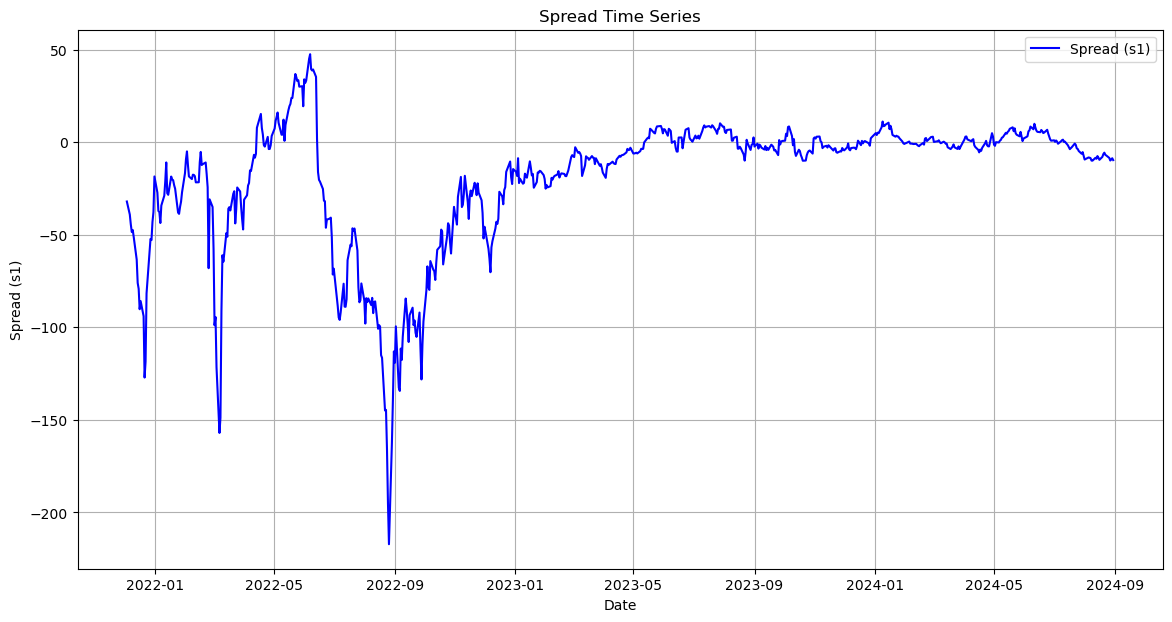

In [110]:
# Time Series Plot of Spread
plt.figure(figsize=(14, 7))
plt.plot(df_pair1.index, df_pair1['s1'], label='Spread (s1)', color='blue')
plt.title("Spread Time Series")
plt.xlabel("Date")
plt.ylabel("Spread (s1)")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1200x600 with 0 Axes>

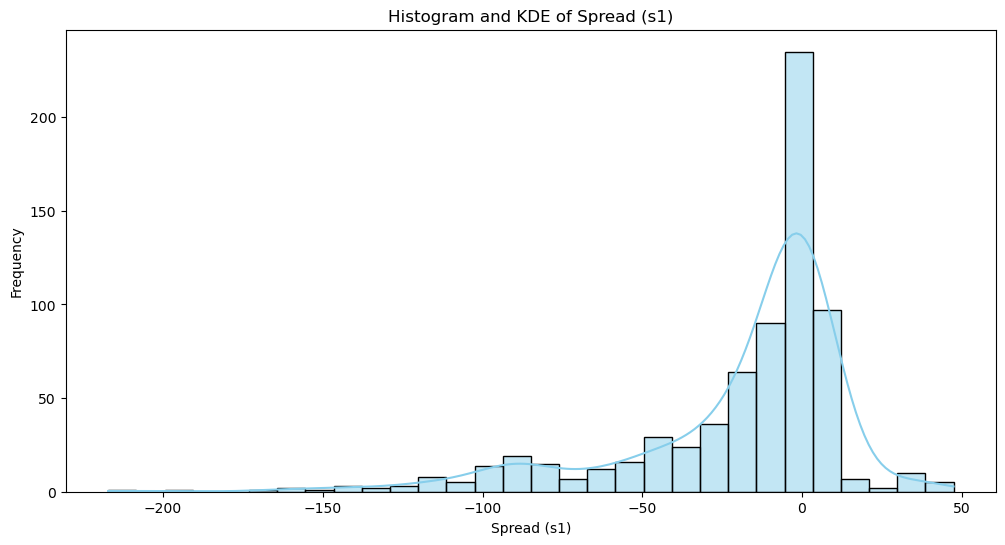

In [112]:
# Histogram with KDE
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df_pair1['s1'], kde=True, bins=30, color='skyblue')
plt.title("Histogram and KDE of Spread (s1)")
plt.xlabel("Spread (s1)")
plt.ylabel("Frequency")
plt.show()


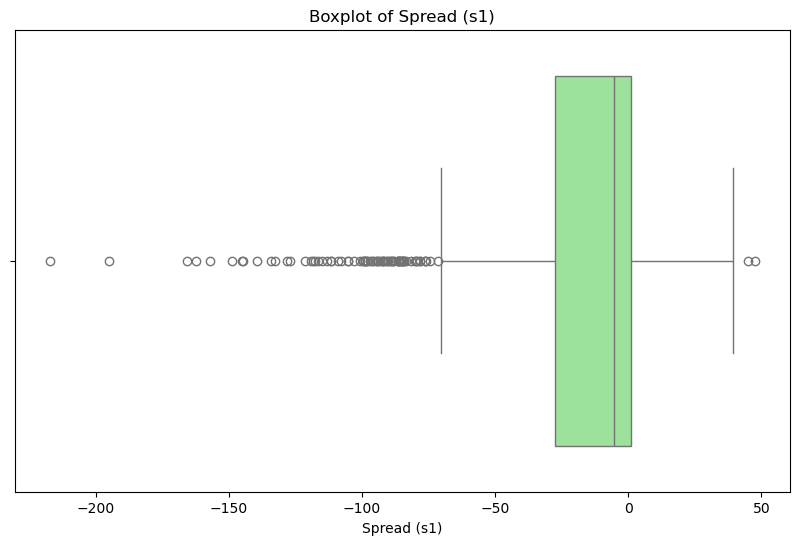

In [113]:
# Boxplot of Spread
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_pair1['s1'], color='lightgreen')
plt.title("Boxplot of Spread (s1)")
plt.xlabel("Spread (s1)")
plt.show()


In [114]:
# Calculate Skewness and Kurtosis
spread_skewness = df_pair1['s1'].skew()
spread_kurtosis = df_pair1['s1'].kurtosis()

print(f"\nSkewness of Spread (s1): {spread_skewness:.4f}")
print(f"Kurtosis of Spread (s1): {spread_kurtosis:.4f}")



Skewness of Spread (s1): -1.8322
Kurtosis of Spread (s1): 3.8601


In [115]:
# Compute specific quantiles
quantiles = df_pair1['s1'].quantile([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print("\nQuantiles of Spread (s1):")
print(quantiles)


Quantiles of Spread (s1):
0.01   -144.209299
0.05    -96.647042
0.25    -27.610917
0.50     -5.405373
0.75      1.209930
0.95      8.811651
0.99     34.981709
Name: s1, dtype: float64


<Figure size 800x600 with 0 Axes>

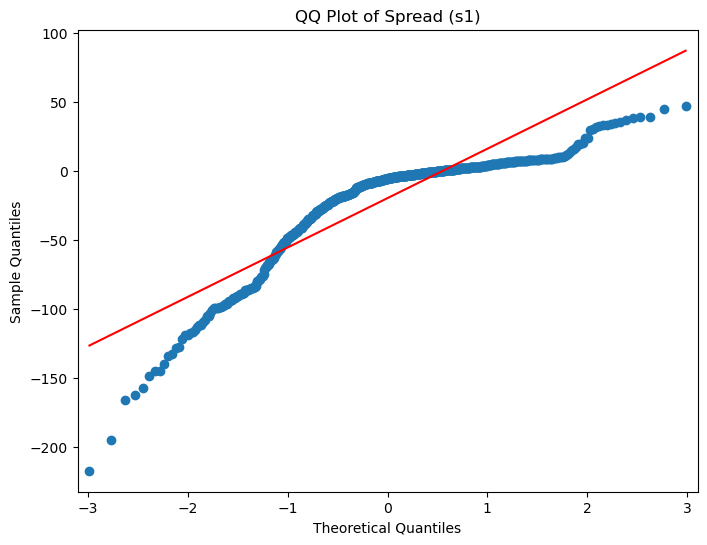

In [117]:
# QQ-Plot for Spread
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

plt.figure(figsize=(8, 6))
qqplot(df_pair1['s1'], line='s', ax=plt.gca())
plt.title("QQ Plot of Spread (s1)")
plt.show()


In [120]:
# Kolmogorov-Smirnov Test for Normality
# Note: The KS test assumes the parameters are known; here, we use sample estimates.

# Standardize the spread
spread_standardized = (df_pair1['s1'] - df_pair1['s1'].mean()) / df_pair1['s1'].std()

ks_stat, ks_pvalue = stats.kstest(spread_standardized, 'norm')
print(f"\nKolmogorov-Smirnov Test for Normality:")
print(f"KS Statistic: {ks_stat:.4f}")
print(f"p-value: {ks_pvalue:.4f}")

# Interpretation
alpha = 0.05
if ks_pvalue < alpha:
    print("Reject the null hypothesis: The spread does not follow a normal distribution.")
else:
    print("Fail to reject the null hypothesis: The spread may follow a normal distribution.")



Kolmogorov-Smirnov Test for Normality:
KS Statistic: 0.2047
p-value: 0.0000
Reject the null hypothesis: The spread does not follow a normal distribution.


In [65]:
df_pair1['s1_zscore'] = (df_pair1['s1'] - df_pair1['s1'].mean()) / df_pair1['s1'].std(ddof=0)
df_pair1['s1_zscore'].describe()

count    7.090000e+02
mean     1.202611e-16
std      1.000706e+00
min     -5.524765e+00
25%     -2.237489e-01
50%      3.972215e-01
75%      5.822161e-01
max      1.875833e+00
Name: s1_zscore, dtype: float64

In [99]:
outliers_s1 = df_pair1[np.abs(df_pair1['s1_zscore']) > 3]
outliers_s1[["date", "W", "X", "s1", "s1_zscore"]]

,date,W,X,s1,s1_zscore
12,2021-12-21,179.978724,52.822475,-127.156249,-3.007499
65,2022-03-07,224.467759,67.402239,-157.065520,-3.843902
66,2022-03-08,212.038966,63.206344,-148.832622,-3.613672
184,2022-08-22,279.362333,134.415761,-144.946572,-3.505000
185,2022-08-23,272.177800,127.561489,-144.616311,-3.495764
186,2022-08-24,295.401667,129.547966,-165.853701,-4.089660
187,2022-08-25,325.372067,130.148086,-195.223981,-4.910990
188,2022-08-26,346.172345,129.000132,-217.172213,-5.524765
189,2022-08-29,292.432000,130.024259,-162.407741,-3.993295
190,2022-08-30,265.487138,125.958480,-139.528658,-3.353490


In [70]:
print(f"Number of outliers in s1 (Z-score>3): {len(outliers_s1)}")

Number of outliers in s1 (Z-score>3): 13


In [71]:
df_pair1['s1'].skew()

-1.8322267019963674

In [74]:
adf_s1 = ts.adfuller(df_pair1['s1'].dropna(), autolag='AIC')

def print_adf_results(adf_res, spread_name):
    print(f"\nADF Test for {spread_name}:")
    print(f"  ADF Statistic: {adf_res[0]}")
    print(f"  p-value:       {adf_res[1]}")
    for key, value in adf_res[4].items():
        print(f"     Critical Value ({key}): {value}")
        
print_adf_results(adf_s1, "s1")


ADF Test for s1:
  ADF Statistic: -3.127999055095128
  p-value:       0.02454933311630283
     Critical Value (1%): -3.4396861854831964
     Critical Value (5%): -2.865660062273053
     Critical Value (10%): -2.5689640195342456


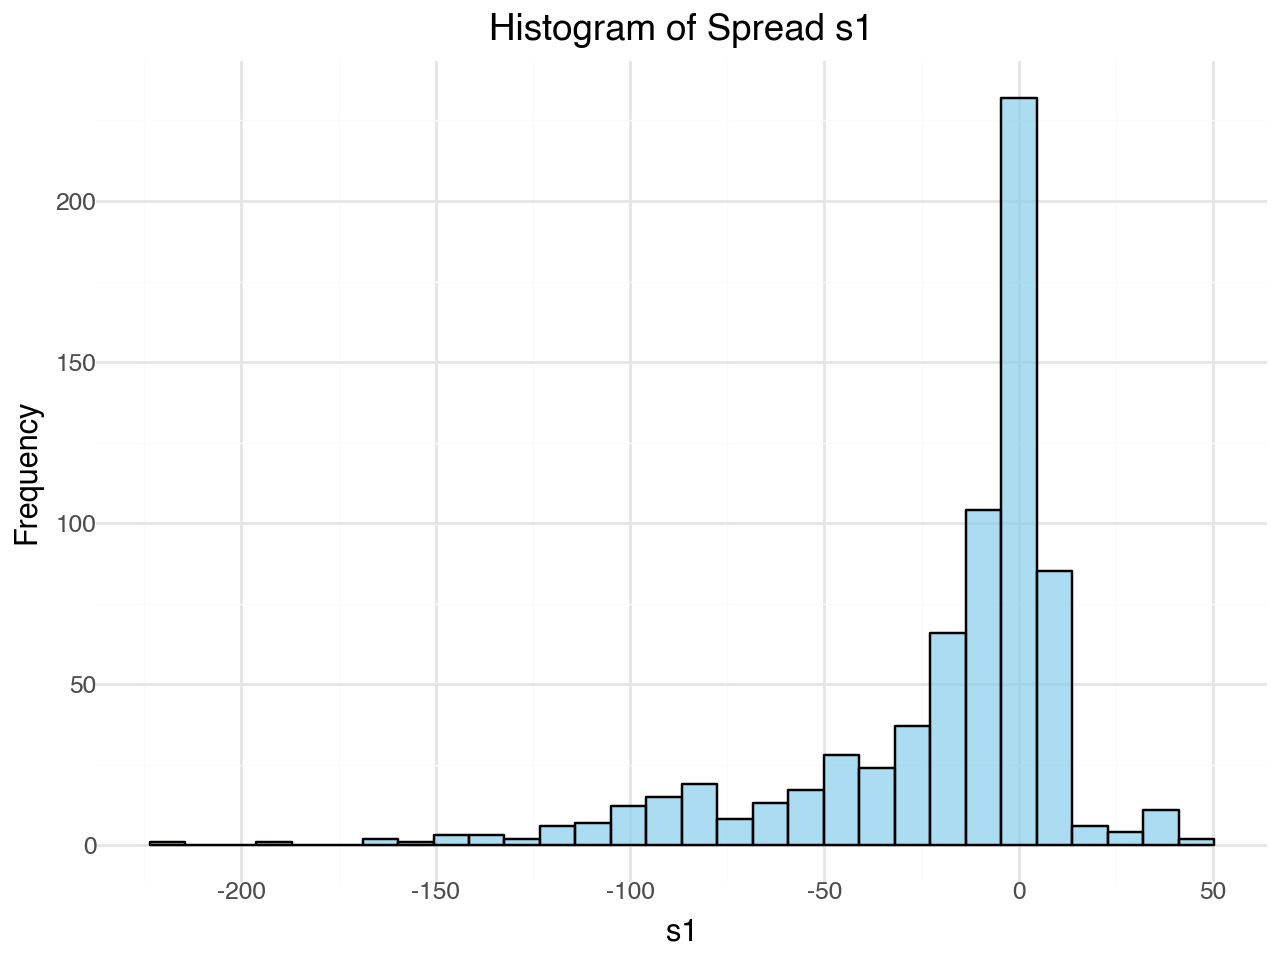

In [79]:
p1_hist = (
    ggplot(df_pair1, aes(x='s1'))
    + geom_histogram(bins=30, fill='skyblue', color='black', alpha=0.7)
    + labs(title='Histogram of Spread s1', x='s1', y='Frequency')
    + theme_minimal()
)
p1_hist

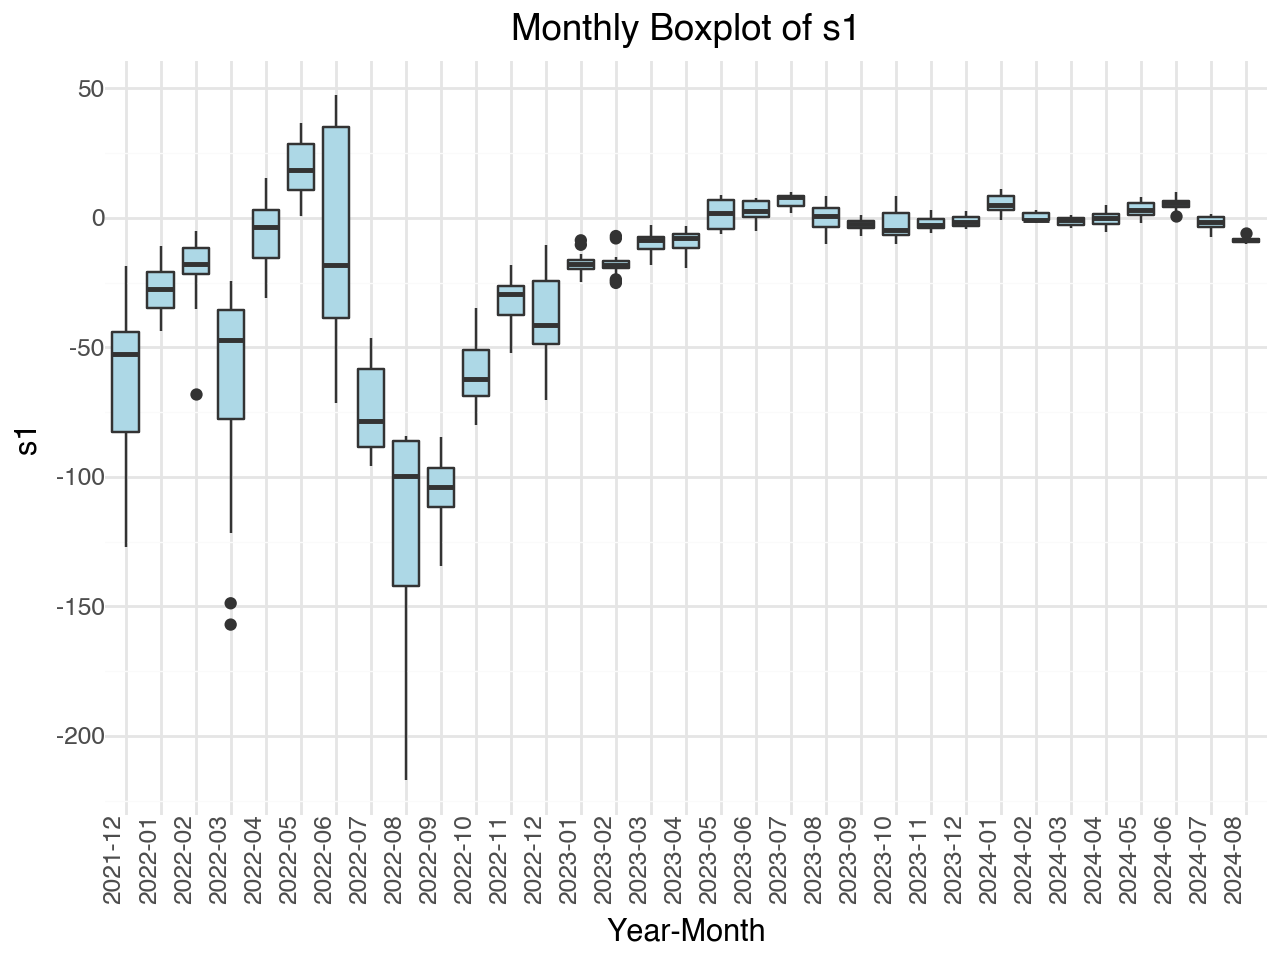

In [81]:
df_pair1['YearMonth'] = df_pair1['date'].dt.to_period('M').astype(str)
p1_box = (
    ggplot(df_pair1, aes(x='YearMonth', y='s1'))
    + geom_boxplot(fill='lightblue')
    + theme_minimal()
    + theme(axis_text_x=element_text(rotation=90, hjust=1))
    + labs(title='Monthly Boxplot of s1', x='Year-Month', y='s1')
)
p1_box

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Assume df_pair1 is the DataFrame with your spread, s1
data = df_pair1['s1'].dropna().values  # Numpy array

# --- 1) Normal Distribution Fit ---
# MLE for normal is straightforward: mean & std from the data
mu_normal, std_normal = np.mean(data), np.std(data, ddof=1)
ll_normal = np.sum(stats.norm.logpdf(data, loc=mu_normal, scale=std_normal))
aic_normal = 2*2 - 2*ll_normal  # 2 params (mu, sigma)
bic_normal = np.log(len(data))*2 - 2*ll_normal

# --- 2) Student's t Distribution Fit ---
# We'll use scipy.stats.t: Need to estimate (df, loc, scale) via MLE.
# Use 'stats.t.fit' which returns (df, loc, scale)
df_t, loc_t, scale_t = stats.t.fit(data)
ll_t = np.sum(stats.t.logpdf(data, df_t, loc_t, scale_t))
# We have 3 parameters: df, loc, scale
aic_t = 2*3 - 2*ll_t
bic_t = np.log(len(data))*3 - 2*ll_t

# --- 3) Skew-t Distribution Fit ---
# statsmodels has a skew-t in 'statsmodels.sandbox.distributions'
# but it's somewhat experimental. Let's do a quick example:
try:
    from statsmodels.sandbox.distributions.extras import skewt
    # The skewt.fit method returns (xi, omega, alpha, nu): shape, scale, skew, and df
    xi_skewt, omega_skewt, alpha_skewt, nu_skewt = skewt.fit(data)
    ll_skewt = np.sum(skewt.logpdf(data, xi_skewt, omega_skewt, alpha_skewt, nu_skewt))
    # 4 parameters: xi, omega, alpha, nu
    aic_skewt = 2*4 - 2*ll_skewt
    bic_skewt = np.log(len(data))*4 - 2*ll_skewt
except ImportError:
    # In case skewt is not available or fails, we skip
    ll_skewt, aic_skewt, bic_skewt = np.nan, np.nan, np.nan
    print("skewt distribution not available in this environment.")

# Summarize results
results = pd.DataFrame({
    'Distribution': ['Normal', "Student's t", 'Skew-t'],
    'Log-Likelihood': [ll_normal, ll_t, ll_skewt],
    'AIC': [aic_normal, aic_t, aic_skewt],
    'BIC': [bic_normal, bic_t, bic_skewt]
})

print("\nDistribution Fit Summary:")
print(results)


skewt distribution not available in this environment.

Distribution Fit Summary:
  Distribution  Log-Likelihood          AIC          BIC
0       Normal    -3541.988886  7087.977772  7097.105483
1  Student's t    -3371.846128  6749.692255  6763.383822
2       Skew-t             NaN          NaN          NaN


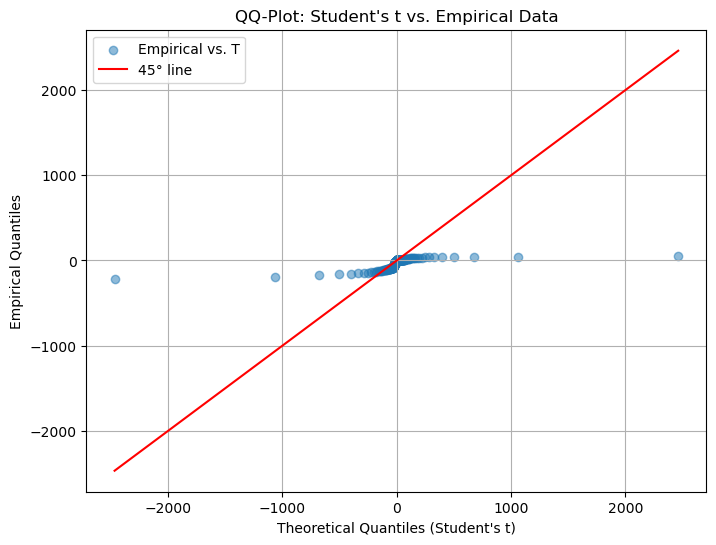

In [125]:
# QQ-Plot: Student's t vs. Data
# We'll generate theoretical quantiles from the fitted Student's t and compare to empirical
sorted_data = np.sort(data)
quantiles = np.linspace(0.001, 0.999, len(data))  # range in (0,1)
theoretical_quantiles = stats.t.ppf(quantiles, df_t, loc_t, scale_t)

plt.figure(figsize=(8,6))
plt.scatter(theoretical_quantiles, sorted_data, alpha=0.5, label="Empirical vs. T")
# 45 degree line
min_val = min(theoretical_quantiles[0], sorted_data[0])
max_val = max(theoretical_quantiles[-1], sorted_data[-1])
plt.plot([min_val, max_val], [min_val, max_val], color='r', label='45° line')
plt.xlabel("Theoretical Quantiles (Student's t)")
plt.ylabel("Empirical Quantiles")
plt.title("QQ-Plot: Student's t vs. Empirical Data")
plt.legend()
plt.grid(True)
plt.show()
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

data_reshaped = data.reshape(-1, 1)
bandwidths = np.linspace(0.5, 5.0, 10)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation
grid.fit(data_reshaped)

best_bw = grid.best_params_['bandwidth']
print(f"Optimal KDE Bandwidth = {best_bw:.2f}")

# Fit final KDE
kde = KernelDensity(kernel='gaussian', bandwidth=best_bw).fit(data_reshaped)

# Evaluate on a grid
x_grid = np.linspace(data.min()-10, data.max()+10, 500)
log_dens = kde.score_samples(x_grid.reshape(-1,1))
pdf_kde = np.exp(log_dens)

plt.figure(figsize=(10,6))
plt.hist(data, density=True, alpha=0.4, bins=30, label='Data Histogram')
plt.plot(x_grid, pdf_kde, 'r-', lw=2, label='KDE (Optimal BW)')
plt.title("Optimal Bandwidth KDE for Spread")
plt.xlabel("Spread (s1)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


Optimal KDE Bandwidth = 5.00


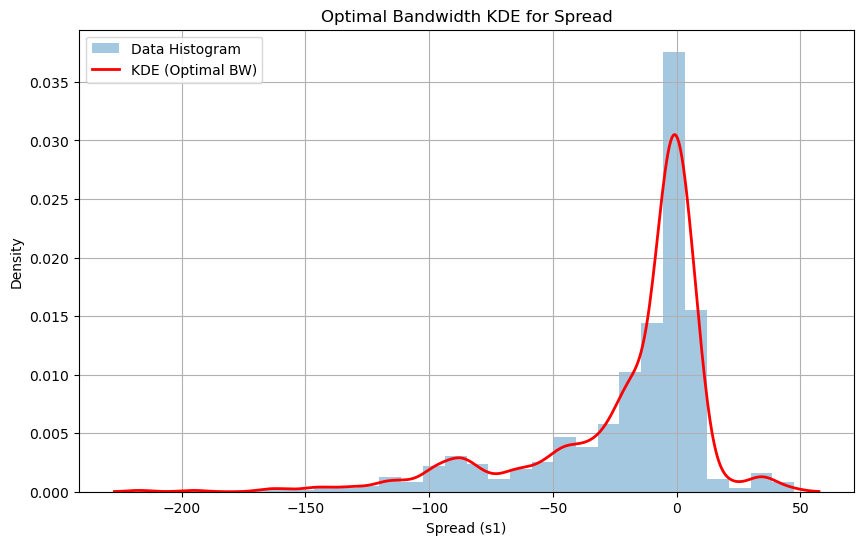

In [126]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

data_reshaped = data.reshape(-1, 1)
bandwidths = np.linspace(0.5, 5.0, 10)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=5)  # 5-fold cross-validation
grid.fit(data_reshaped)

best_bw = grid.best_params_['bandwidth']
print(f"Optimal KDE Bandwidth = {best_bw:.2f}")

# Fit final KDE
kde = KernelDensity(kernel='gaussian', bandwidth=best_bw).fit(data_reshaped)

# Evaluate on a grid
x_grid = np.linspace(data.min()-10, data.max()+10, 500)
log_dens = kde.score_samples(x_grid.reshape(-1,1))
pdf_kde = np.exp(log_dens)

plt.figure(figsize=(10,6))
plt.hist(data, density=True, alpha=0.4, bins=30, label='Data Histogram')
plt.plot(x_grid, pdf_kde, 'r-', lw=2, label='KDE (Optimal BW)')
plt.title("Optimal Bandwidth KDE for Spread")
plt.xlabel("Spread (s1)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


In [127]:
import random

N_BOOT = 1000
boot_means = []
boot_skews = []
boot_q05 = []
boot_q95 = []

n = len(data)
for _ in range(N_BOOT):
    sample = np.random.choice(data, size=n, replace=True)
    boot_means.append(np.mean(sample))
    boot_skews.append(stats.skew(sample))
    boot_q05.append(np.quantile(sample, 0.05))
    boot_q95.append(np.quantile(sample, 0.95))

boot_means = np.array(boot_means)
boot_skews = np.array(boot_skews)
boot_q05 = np.array(boot_q05)
boot_q95 = np.array(boot_q95)

mean_ci = (np.percentile(boot_means, 2.5), np.percentile(boot_means, 97.5))
skew_ci = (np.percentile(boot_skews, 2.5), np.percentile(boot_skews, 97.5))
q05_ci  = (np.percentile(boot_q05, 2.5), np.percentile(boot_q05, 97.5))
q95_ci  = (np.percentile(boot_q95, 2.5), np.percentile(boot_q95, 97.5))

print("\n--- Bootstrap Confidence Intervals ---")
print(f"Mean 95% CI: {mean_ci}")
print(f"Skewness 95% CI: {skew_ci}")
print(f"5% Quantile 95% CI: {q05_ci}")
print(f"95% Quantile 95% CI: {q95_ci}")



--- Bootstrap Confidence Intervals ---
Mean 95% CI: (-22.128687522306695, -16.818147058968687)
Skewness 95% CI: (-2.1416061591386466, -1.5313352123459372)
5% Quantile 95% CI: (-104.31580964000001, -89.41414516657083)
95% Quantile 95% CI: (8.161320821875002, 11.411034412600806)


In [129]:
threshold = np.percentile(data, 5)  # 5th percentile, e.g. -96.65 in your data
exceedances = data[data < threshold]
exceedances

array([-127.15624892, -118.55523352,  -98.90385745, -121.59423941,
       -157.06551967, -148.83262185,  -97.99897881, -100.82631088,
        -98.85714835,  -99.59336387, -115.07306027, -116.5118176 ,
       -144.94657229, -144.61631085, -165.85370107, -195.22398098,
       -217.17221271, -162.40774095, -139.52865768, -113.04536318,
       -119.174013  ,  -99.502485  , -132.652485  , -134.3669332 ,
       -111.4932661 , -117.6435931 , -105.2711484 ,  -98.2716087 ,
       -107.9471092 ,  -98.8874492 , -102.9923873 , -105.1980912 ,
       -111.6893765 , -128.17592   , -109.1885062 ,  -96.8566465 ])

In [130]:
from scipy.stats import genpareto

# We'll transform the negative tail to positive by subtracting the threshold
excess = -(exceedances - threshold)  # so "excess" is positive
shape, loc, scale = genpareto.fit(excess, loc=0)
print("\n--- GPD Fit (Negative Tail) ---")
print(f"Threshold: {threshold:.4f}")
print(f"Shape: {shape:.4f}, Loc: {loc:.4f}, Scale: {scale:.4f}")

# Check log-likelihood or AIC if desired
ll_gpd = np.sum(genpareto.logpdf(excess, shape, loc=loc, scale=scale))
aic_gpd = 2*2 - 2*ll_gpd  # shape, scale are 2 params (loc=0 fixed in this transformation)
print(f"GPD Log-Likelihood: {ll_gpd:.2f}")
print(f"GPD AIC: {aic_gpd:.2f}")



--- GPD Fit (Negative Tail) ---
Threshold: -96.6470
Shape: 0.0441, Loc: 0.2096, Scale: 25.9308
GPD Log-Likelihood: -154.78
GPD AIC: 313.57


In [131]:
def gpd_var_es(prob, threshold, shape, scale):
    """
    Estimate VaR and Expected Shortfall at tail probability `prob` 
    using the fitted GPD parameters for exceedances.
    """
    # VaR is threshold + -some quantile => Since we have negative tail, adapt sign
    # CDF for GPD is 1 - (1 + shape*x/scale)^(-1/shape)
    # Solve for x s.t. F(x) = prob, i.e. x = scale/shape*((1 - prob)^(-shape) - 1)
    
    # BUT we have already subtracted threshold. 
    # We'll be consistent and interpret properly.
    alpha = 1 - prob  # e.g. if prob=0.99, alpha=0.01 tail
    if shape != 0:
        var_excess = scale/shape*((alpha)**(-shape) - 1)
    else:
        var_excess = scale * np.log(1/alpha)
    
    var = threshold - var_excess  # since threshold is negative and var_excess is positive
    
    # Expected Shortfall (ES): ES = VaR + [ scale - shape*VaR + ??? ] (there's a known formula)
    # GPD ES above threshold for alpha-tail:
    # ES = var_excess / (1 - shape) + ...
    # Let's do a direct formula for negative tail:
    if shape < 1:
        es_excess = (var_excess/(1 - shape)) + scale - shape*threshold
        es = threshold - es_excess
    else:
        es = np.nan  # infinite or undefined if shape >= 1
    
    return var, es

# For a 95% VaR (i.e., prob=0.95 => alpha=0.05 tail)
var_95, es_95 = gpd_var_es(prob=0.95, threshold=threshold, shape=shape, scale=scale)
print(f"95% VaR (negative tail) ~ {var_95:.2f}")
print(f"95% Expected Shortfall (negative tail) ~ {es_95:.2f}")


95% VaR (negative tail) ~ -179.70
95% Expected Shortfall (negative tail) ~ -213.73


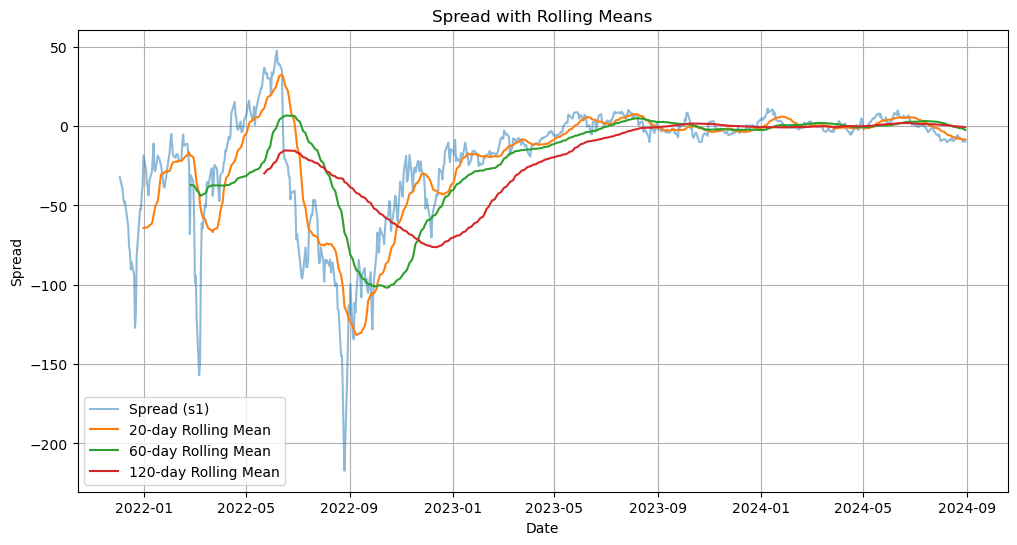

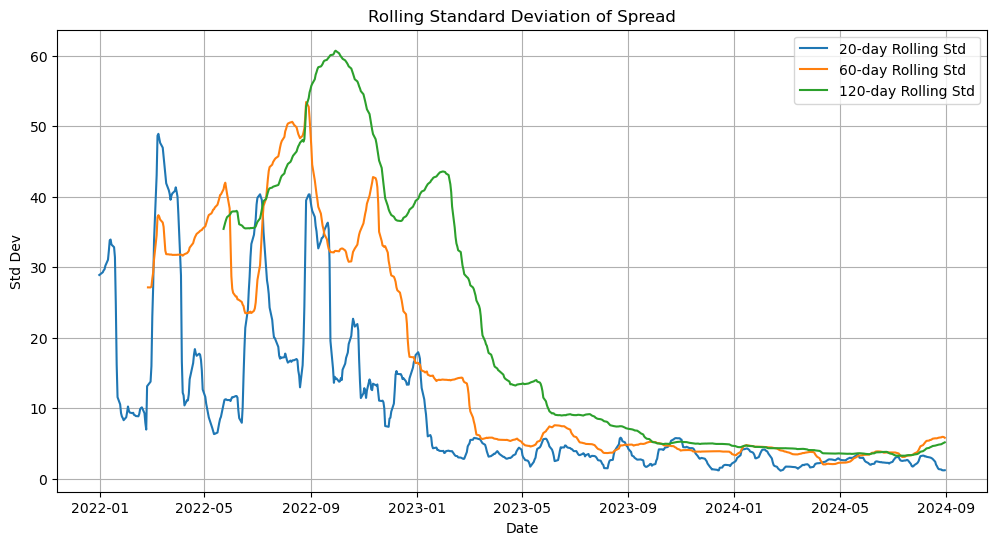

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_pair1.copy()
window_sizes = [20, 60, 120]  # Example: 20-day, 60-day, 120-day

for w in window_sizes:
    df[f'roll_mean_{w}'] = df['s1'].rolling(w).mean()
    df[f'roll_std_{w}']  = df['s1'].rolling(w).std()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['s1'], label='Spread (s1)', alpha=0.5)
for w in window_sizes:
    plt.plot(df.index, df[f'roll_mean_{w}'], label=f'{w}-day Rolling Mean')
plt.title("Spread with Rolling Means")
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
for w in window_sizes:
    plt.plot(df.index, df[f'roll_std_{w}'], label=f'{w}-day Rolling Std')
plt.title("Rolling Standard Deviation of Spread")
plt.xlabel("Date")
plt.ylabel("Std Dev")
plt.legend()
plt.grid(True)
plt.show()


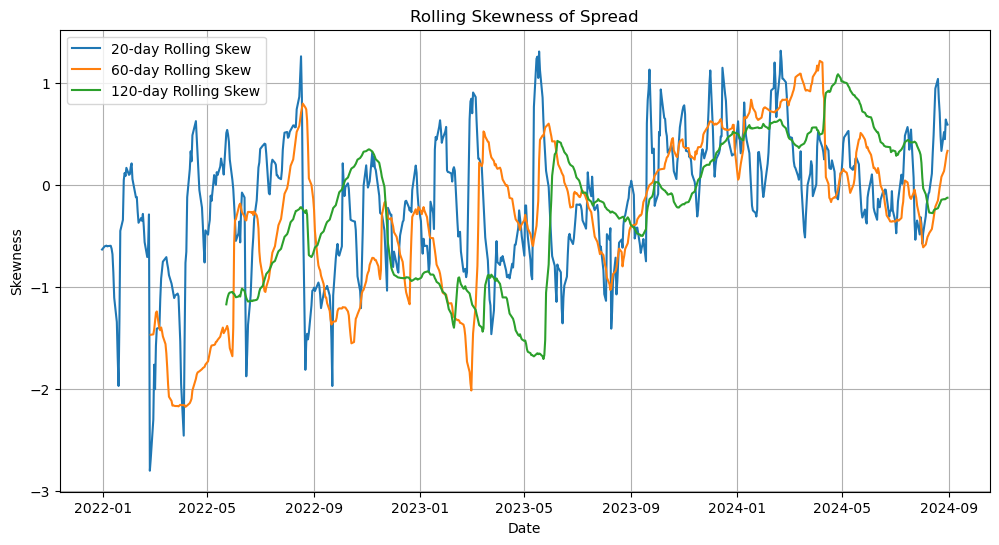

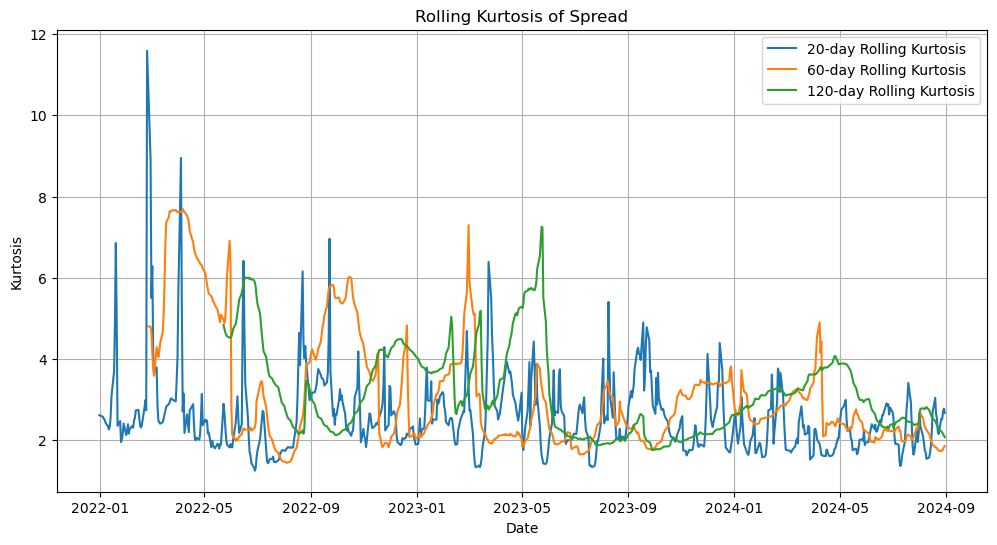

In [133]:
from scipy.stats import skew, kurtosis

for w in window_sizes:
    df[f'roll_skew_{w}'] = df['s1'].rolling(w).apply(lambda x: skew(x.dropna()), raw=False)
    df[f'roll_kurt_{w}'] = df['s1'].rolling(w).apply(lambda x: kurtosis(x.dropna(), fisher=False), raw=False)
    # fisher=False => moment-based definition with kurtosis=3 for normal

plt.figure(figsize=(12,6))
plt.plot(df.index, df['roll_skew_20'], label='20-day Rolling Skew')
plt.plot(df.index, df['roll_skew_60'], label='60-day Rolling Skew')
plt.plot(df.index, df['roll_skew_120'], label='120-day Rolling Skew')
plt.title("Rolling Skewness of Spread")
plt.xlabel("Date")
plt.ylabel("Skewness")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,6))
plt.plot(df.index, df['roll_kurt_20'], label='20-day Rolling Kurtosis')
plt.plot(df.index, df['roll_kurt_60'], label='60-day Rolling Kurtosis')
plt.plot(df.index, df['roll_kurt_120'], label='120-day Rolling Kurtosis')
plt.title("Rolling Kurtosis of Spread")
plt.xlabel("Date")
plt.ylabel("Kurtosis")
plt.legend()
plt.grid(True)
plt.show()


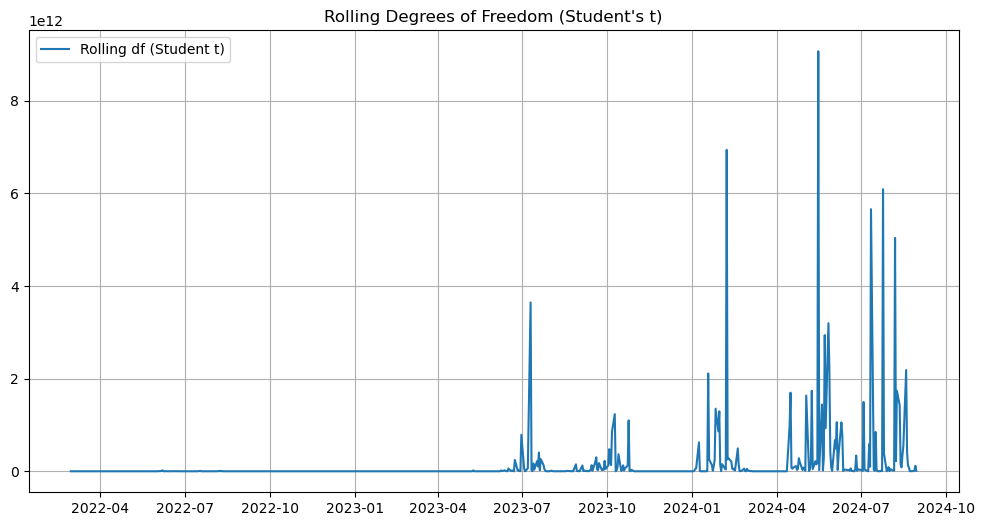

In [134]:
from scipy.stats import t

window = 60  # example rolling window
df['df_t'] = np.nan
df['loc_t'] = np.nan
df['scale_t'] = np.nan

for i in range(window, len(df)):
    sample = df['s1'].iloc[i-window:i].dropna().values
    if len(sample) > 0:
        df_val, loc_val, scale_val = t.fit(sample)
        df.loc[df.index[i], 'df_t'] = df_val
        df.loc[df.index[i], 'loc_t'] = loc_val
        df.loc[df.index[i], 'scale_t'] = scale_val

plt.figure(figsize=(12,6))
plt.plot(df.index, df['df_t'], label='Rolling df (Student t)')
plt.title("Rolling Degrees of Freedom (Student's t)")
plt.grid(True)
plt.legend()
plt.show()


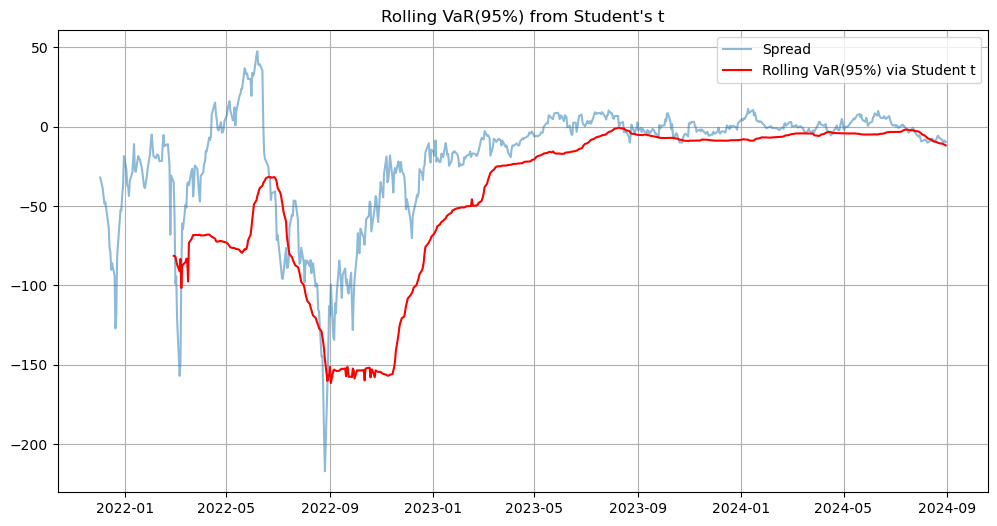

In [135]:
def student_t_var(series, alpha=0.95):
    df_val, loc_val, scale_val = t.fit(series)
    # For VaR at alpha (one-tailed), we want the quantile for the left tail
    q_t = t.ppf(1-alpha, df_val, loc=loc_val, scale=scale_val)  
    return q_t

window = 60
df['var_95_t'] = np.nan
for i in range(window, len(df)):
    sample = df['s1'].iloc[i-window:i].dropna().values
    if len(sample) > 0:
        df.loc[df.index[i], 'var_95_t'] = student_t_var(sample, alpha=0.95)

plt.figure(figsize=(12,6))
plt.plot(df.index, df['s1'], alpha=0.5, label='Spread')
plt.plot(df.index, df['var_95_t'], color='red', label='Rolling VaR(95%) via Student t')
plt.title("Rolling VaR(95%) from Student's t")
plt.legend()
plt.grid(True)
plt.show()
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

# We'll assume you have df_pair1['s1'] as your spread time series
df_spread = df_pair1[['s1']].dropna()

# 1) Compute ACF/PACF arrays
lags = 40  # up to 40 lags or as needed
acf_vals = acf(df_spread['s1'], nlags=lags, fft=False)     # fft=False for smaller sample size
pacf_vals = pacf(df_spread['s1'], nlags=lags, method='ols')# or 'yw', 'ld', 'ols'

# 2) Plot ACF
fig, ax = plt.subplots(1,2, figsize=(14,5))
sm.graphics.tsa.plot_acf(df_spread['s1'], lags=lags, ax=ax[0], title="ACF - Spread (s1)")
sm.graphics.tsa.plot_pacf(df_spread['s1'], lags=lags, ax=ax[1], title="PACF - Spread (s1)")
plt.tight_layout()
plt.show()

# If you want to do them in separate figure calls:
# sm.graphics.tsa.plot_acf(df_spread['s1'], lags=40)
# plt.show()
# sm.graphics.tsa.plot_pacf(df_spread['s1'], lags=40)
# plt.show()


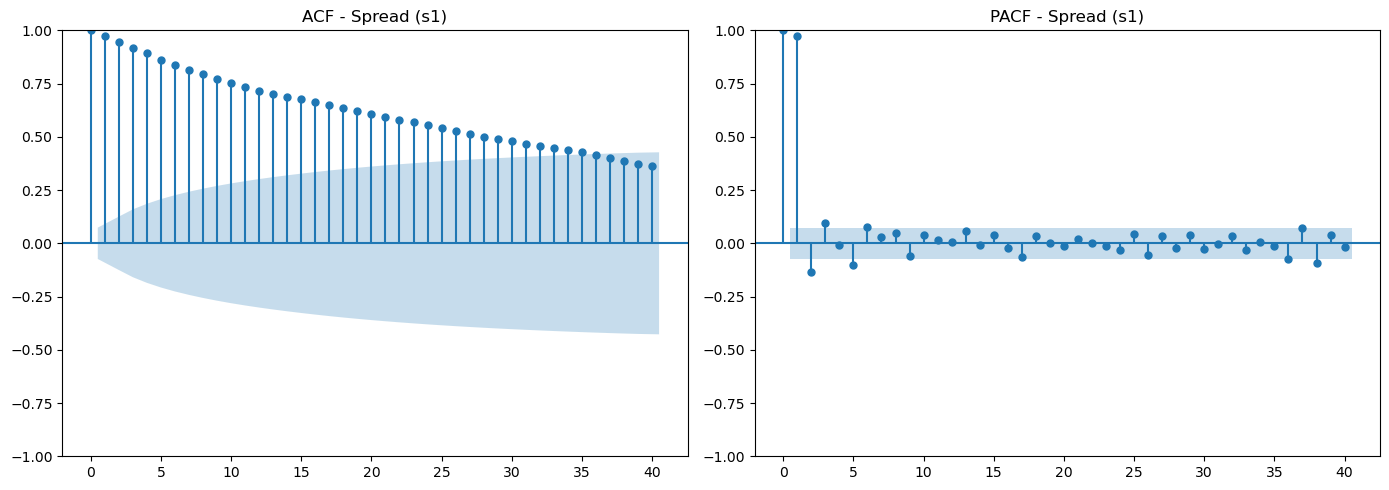

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

# We'll assume you have df_pair1['s1'] as your spread time series
df_spread = df_pair1[['s1']].dropna()

# 1) Compute ACF/PACF arrays
lags = 40  # up to 40 lags or as needed
acf_vals = acf(df_spread['s1'], nlags=lags, fft=False)     # fft=False for smaller sample size
pacf_vals = pacf(df_spread['s1'], nlags=lags, method='ols')# or 'yw', 'ld', 'ols'

# 2) Plot ACF
fig, ax = plt.subplots(1,2, figsize=(14,5))
sm.graphics.tsa.plot_acf(df_spread['s1'], lags=lags, ax=ax[0], title="ACF - Spread (s1)")
sm.graphics.tsa.plot_pacf(df_spread['s1'], lags=lags, ax=ax[1], title="PACF - Spread (s1)")
plt.tight_layout()
plt.show()

# If you want to do them in separate figure calls:
# sm.graphics.tsa.plot_acf(df_spread['s1'], lags=40)
# plt.show()
# sm.graphics.tsa.plot_pacf(df_spread['s1'], lags=40)
# plt.show()


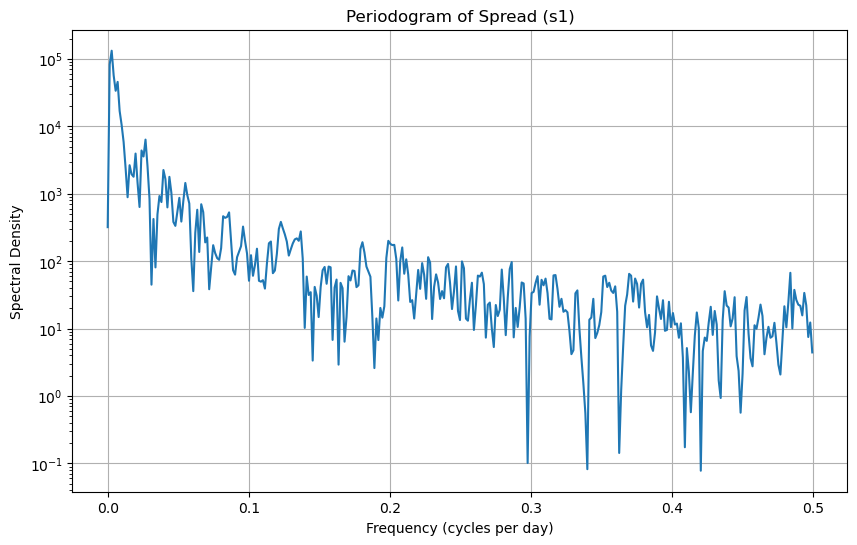

In [137]:
import numpy as np
from scipy.signal import periodogram

data = df_spread['s1'].values
fs = 1.0  # sampling frequency => 1 observation per day (or per time step). Adjust if needed.

freqs, pxx = periodogram(data, fs=fs, window='hann', detrend='linear', scaling='density')

plt.figure(figsize=(10,6))
plt.semilogy(freqs, pxx)  # semilog-y is typical for spectral plots
plt.title("Periodogram of Spread (s1)")
plt.xlabel("Frequency (cycles per day)")
plt.ylabel("Spectral Density")
plt.grid(True)
plt.show()


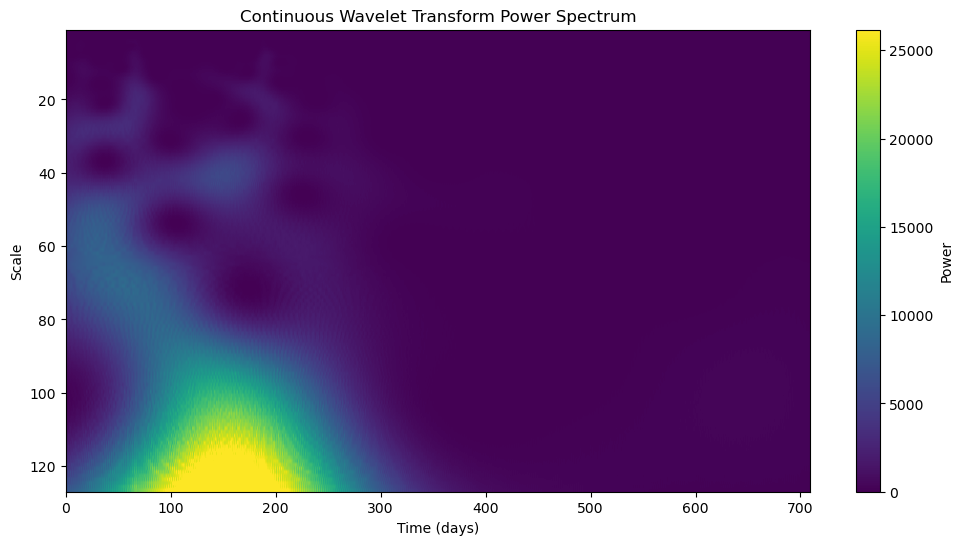

In [138]:
import pywt
import numpy as np
import matplotlib.pyplot as plt

# We'll do a continuous wavelet transform example
# Make sure pywt is installed: pip install PyWavelets
data = df_spread['s1'].values
dt = 1.0  # 1 day per observation
wavelet = 'cmor1.5-1.0'  # A complex Morlet wavelet
scales = np.arange(1,128)  # choose an appropriate range of scales

coeffs, freqs = pywt.cwt(data, scales, wavelet, dt)
power = (np.abs(coeffs))**2

plt.figure(figsize=(12,6))
plt.imshow(power, extent=[0, len(data)*dt, scales[-1], scales[0]], cmap='viridis', aspect='auto',
           vmax=np.percentile(power, 99))  # limit max color to highlight structure
plt.colorbar(label='Power')
plt.title("Continuous Wavelet Transform Power Spectrum")
plt.xlabel("Time (days)")
plt.ylabel("Scale")
plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.1/308.1 kB 3.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ruptures: filename=ruptures-1.1.9-cp312-cp312-macosx_11_0_arm64.whl size=466547 sha256=0743ef58b02ec6a80931d424099b520d0b454bc087cf63eafc0108eb87ee57c7
  Stored in directory: /Users/anandtheerthanakhate/Library/Caches/pip/wheels/99/2d/4d/15931b829a4f53921dcbbb6de97e7cc2a6d2f09ea1428af028
Successfully built ruptures
Breakpoints (end of segments): [90, 145, 180, 220, 270, 709]


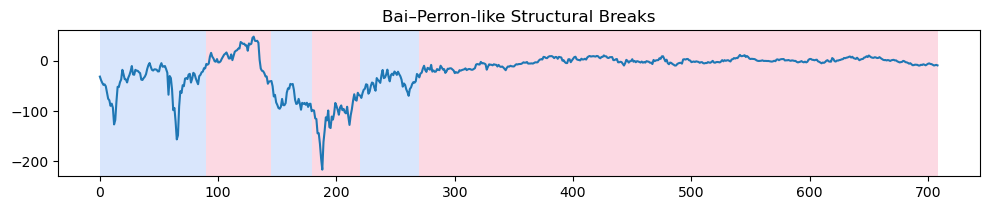

In [140]:
!pip install ruptures
import ruptures as rpt

series = df_pair1['s1'].values
algo = rpt.Binseg(model="l2").fit(series)
# You can specify max number of breaks or penalty
breakpoints = algo.predict(n_bkps=5)  # e.g. up to 5 breakpoints

print("Breakpoints (end of segments):", breakpoints)
# This returns indices where breaks occur

# Visualization
rpt.display(series, breakpoints)
plt.title("Bai–Perron-like Structural Breaks")
plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.1/196.1 kB 3.8 MB/s eta 0:00:00a 0:00:01
Means of each state: [[0.02672308]
 [0.03838996]]
Variances of each state: [[[  4.46475217]]

 [[148.30994725]]]


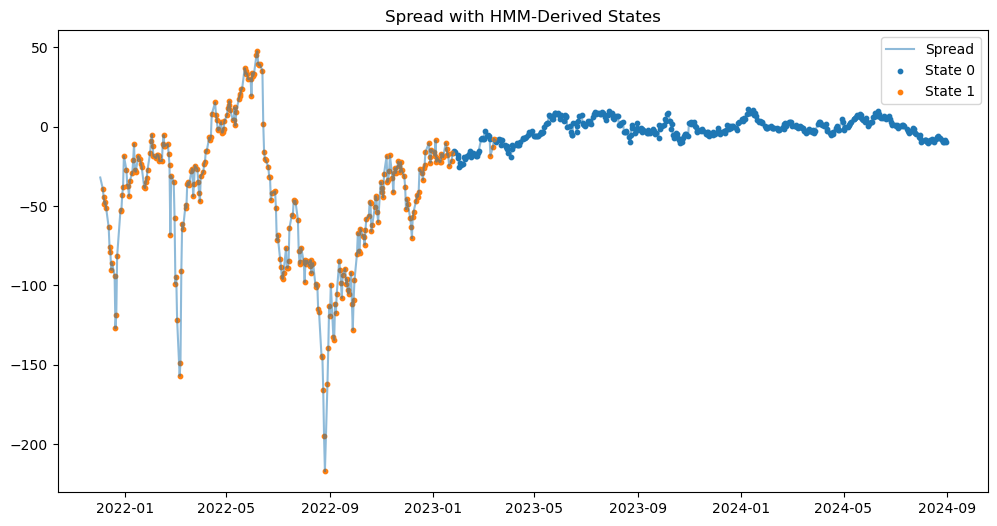

In [142]:
!pip install hmmlearn
import numpy as np
from hmmlearn.hmm import GaussianHMM

returns = df_pair1['s1'].diff().dropna().values.reshape(-1,1)  # or s1_zscore, etc.
num_states = 2  # try 2-state HMM
model = GaussianHMM(n_components=num_states, covariance_type="full", n_iter=100, random_state=42)
model.fit(returns)

# Predict hidden states
states = model.predict(returns)
df_pair1.loc[df_pair1.index[1:], 'HMM_State'] = states  # shift by 1 if needed

print("Means of each state:", model.means_)
print("Variances of each state:", model.covars_)

# Visualization
plt.figure(figsize=(12,6))
plt.plot(df_pair1.index, df_pair1['s1'], alpha=0.5, label='Spread')
for i in range(num_states):
    mask = (df_pair1['HMM_State'] == i)
    plt.scatter(df_pair1.index[mask], df_pair1['s1'][mask], label=f"State {i}", s=10)
plt.title("Spread with HMM-Derived States")
plt.legend()
plt.show()


In [82]:
windows = [5, 10, 21]  # e.g., 1 week, 2 weeks, ~1 month

deviation_stats = {}

for window in windows:
    roll_mean_col = f's1_roll_{window}'
    deviation_col = f'd1_{window}'
    
    # Calculate rolling mean and deviation for window = N
    df_pair1[roll_mean_col] = df_pair1['s1'].rolling(window=window, min_periods=1).mean()
    df_pair1[deviation_col] = df_pair1['s1'] - df_pair1[roll_mean_col]
    
    # Get statistics for this deviation
    deviation_stats[deviation_col] = df_pair1[deviation_col].describe()
    
    print(f"\n=== Deviation Stats for a {window}-day Rolling Window ({deviation_col}) ===")
    print(df_pair1[deviation_col].describe())
    # Also, additional quantiles can be viewed:
    print("Additional quantiles:")
    print(df_pair1[deviation_col].quantile([0.01, 0.05, 0.95, 0.99]))
    


=== Deviation Stats for a 5-day Rolling Window (d1_5) ===
count    709.000000
mean       0.073164
std        9.136830
min      -51.101078
25%       -2.017955
50%        0.071589
75%        2.428218
max       54.857306
Name: d1_5, dtype: float64
Additional quantiles:
0.01   -31.789210
0.05   -12.539649
0.95    12.348581
0.99    31.399725
Name: d1_5, dtype: float64

=== Deviation Stats for a 10-day Rolling Window (d1_10) ===
count    709.000000
mean       0.194278
std       13.746225
min      -86.517927
25%       -2.457438
50%        0.329703
75%        3.860564
max       52.645788
Name: d1_10, dtype: float64
Additional quantiles:
0.01   -49.945531
0.05   -23.335363
0.95    19.940952
0.99    39.256717
Name: d1_10, dtype: float64

=== Deviation Stats for a 21-day Rolling Window (d1_21) ===
count    709.000000
mean       0.572483
std       18.452326
min     -115.444742
25%       -3.311374
50%        0.976981
75%        7.618299
max       46.099282
Name: d1_21, dtype: float64
Additional qu

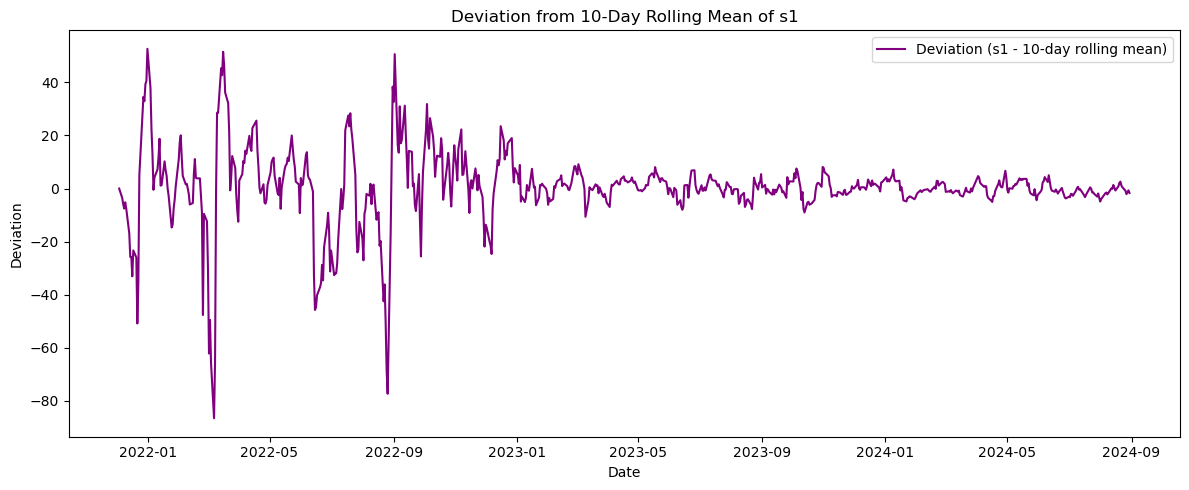

In [84]:
plt.figure(figsize=(12,5))
plt.plot(df_pair1['date'], df_pair1['d1_10'], label='Deviation (s1 - 10-day rolling mean)', color='purple')
plt.xlabel("Date")
plt.ylabel("Deviation")
plt.title("Deviation from 10-Day Rolling Mean of s1")
plt.legend()
plt.tight_layout()
plt.show()

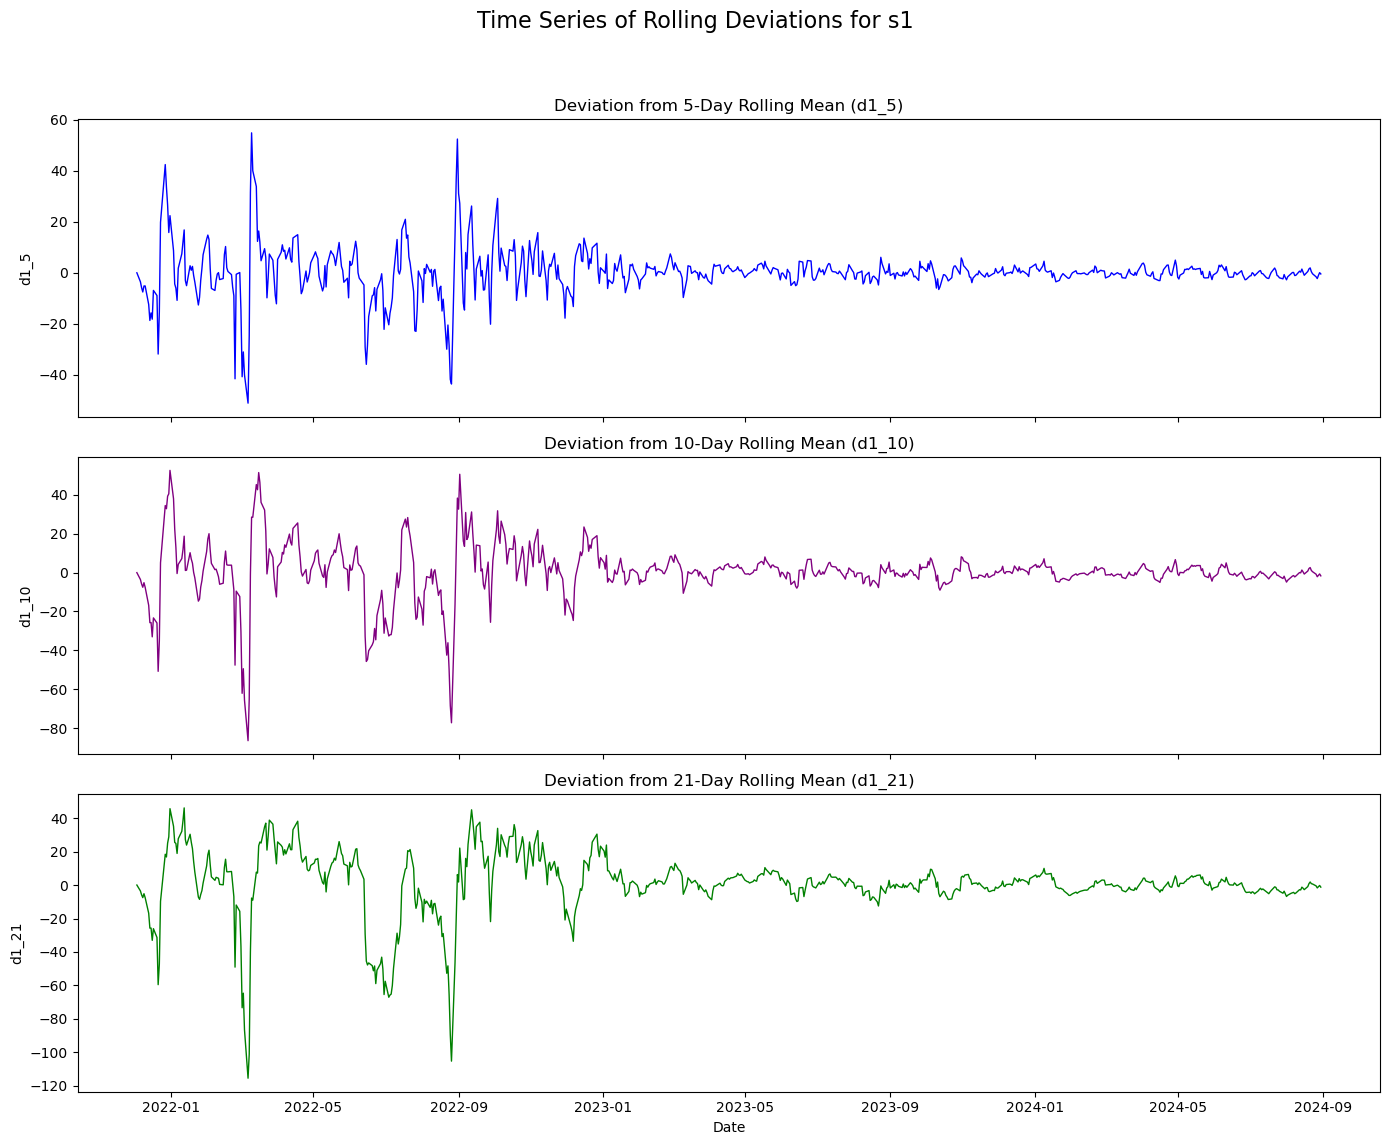

In [85]:

fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle('Time Series of Rolling Deviations for s1', fontsize=16)

# Plot for 5-day window
axs[0].plot(df_pair1['date'], df_pair1['d1_5'], color='blue', lw=1)
axs[0].set_title('Deviation from 5-Day Rolling Mean (d1_5)')
axs[0].set_ylabel('d1_5')

# Plot for 10-day window
axs[1].plot(df_pair1['date'], df_pair1['d1_10'], color='purple', lw=1)
axs[1].set_title('Deviation from 10-Day Rolling Mean (d1_10)')
axs[1].set_ylabel('d1_10')

# Plot for 21-day window
axs[2].plot(df_pair1['date'], df_pair1['d1_21'], color='green', lw=1)
axs[2].set_title('Deviation from 21-Day Rolling Mean (d1_21)')
axs[2].set_ylabel('d1_21')
axs[2].set_xlabel('Date')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


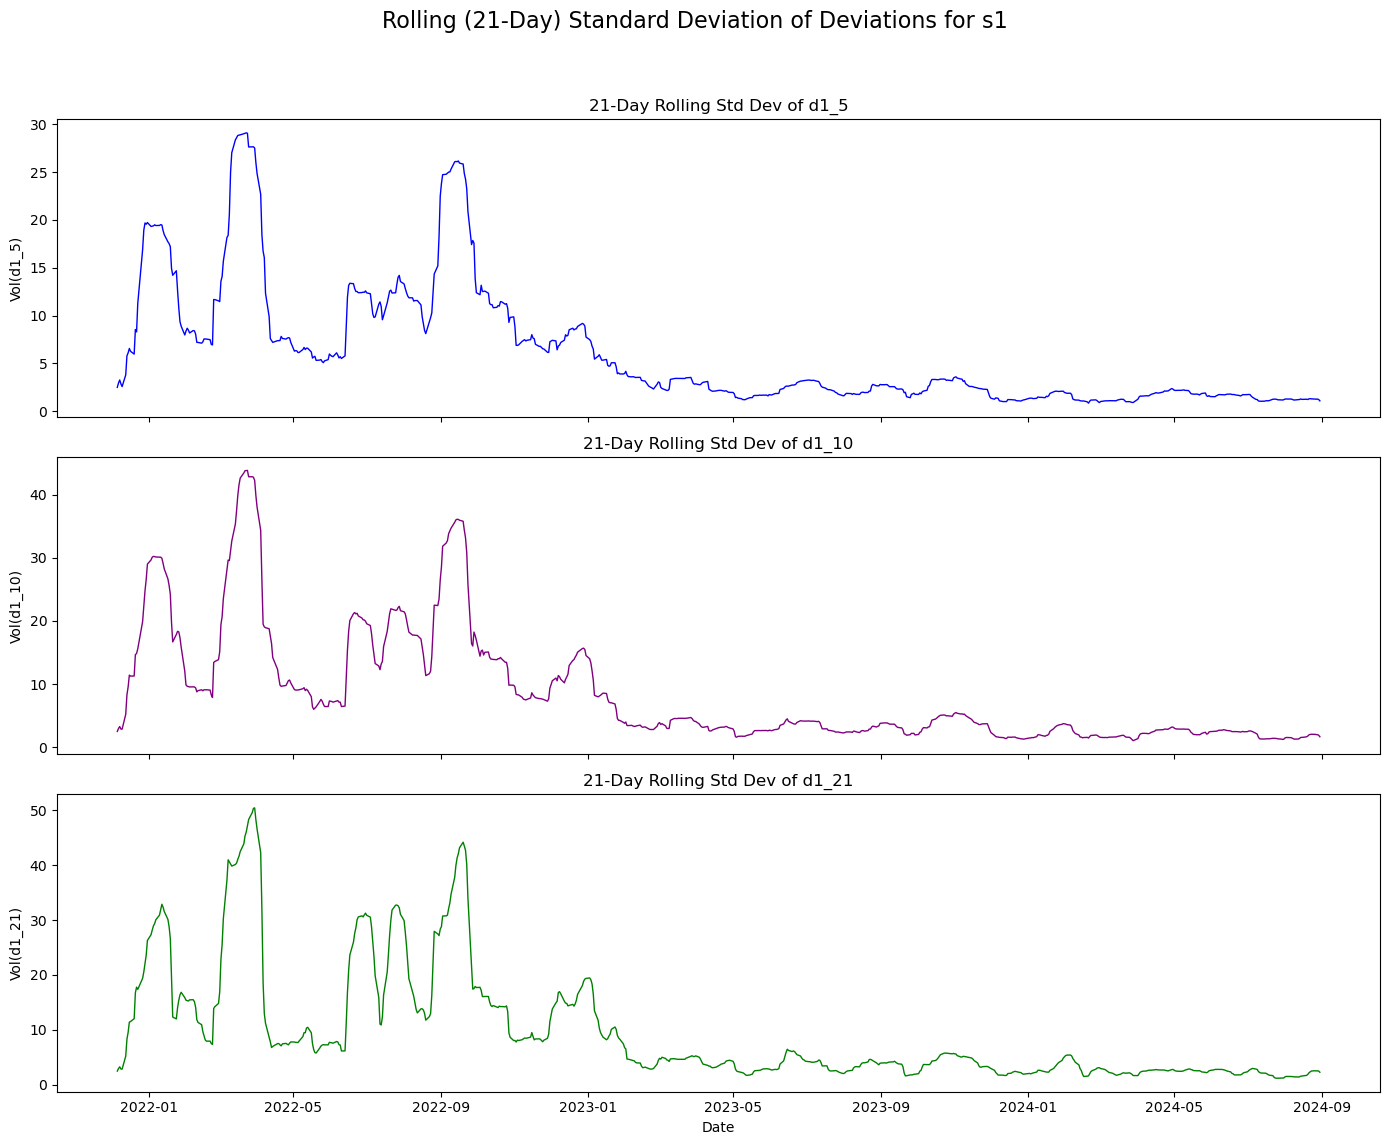

In [86]:
roll_window = 21  # you can adjust the window for the rolling volatility

df_pair1['d1_5_vol'] = df_pair1['d1_5'].rolling(window=roll_window, min_periods=1).std()
df_pair1['d1_10_vol'] = df_pair1['d1_10'].rolling(window=roll_window, min_periods=1).std()
df_pair1['d1_21_vol'] = df_pair1['d1_21'].rolling(window=roll_window, min_periods=1).std()

fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
fig.suptitle('Rolling (21-Day) Standard Deviation of Deviations for s1', fontsize=16)

# Plot rolling volatility for 5-day deviations
axs[0].plot(df_pair1['date'], df_pair1['d1_5_vol'], color='blue', lw=1)
axs[0].set_title('21-Day Rolling Std Dev of d1_5')
axs[0].set_ylabel('Vol(d1_5)')

# Plot rolling volatility for 10-day deviations
axs[1].plot(df_pair1['date'], df_pair1['d1_10_vol'], color='purple', lw=1)
axs[1].set_title('21-Day Rolling Std Dev of d1_10')
axs[1].set_ylabel('Vol(d1_10)')

# Plot rolling volatility for 21-day deviations
axs[2].plot(df_pair1['date'], df_pair1['d1_21_vol'], color='green', lw=1)
axs[2].set_title('21-Day Rolling Std Dev of d1_21')
axs[2].set_ylabel('Vol(d1_21)')
axs[2].set_xlabel('Date')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

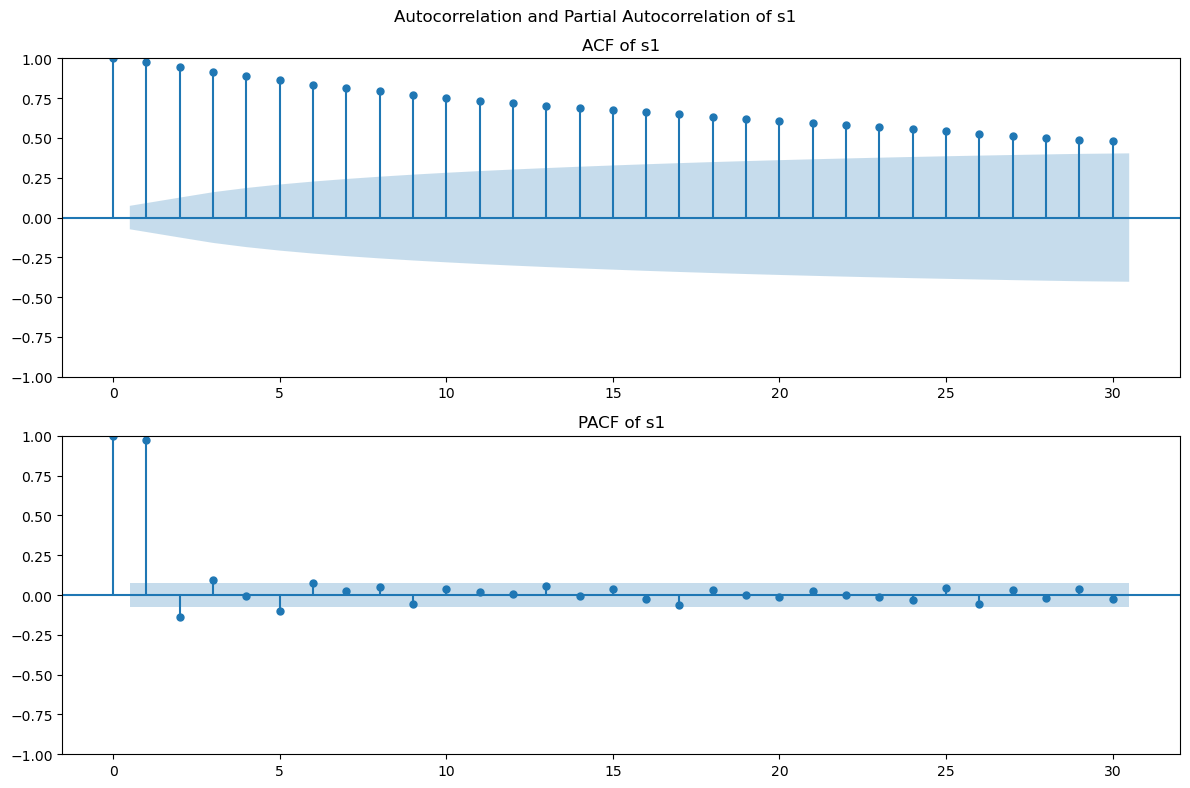

In [87]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

s1_series = df_pair1['s1'].dropna()

# 1. Autocorrelation plot
fig, axes = plt.subplots(2,1, figsize=(12,8))
fig.suptitle("Autocorrelation and Partial Autocorrelation of s1")

sm.graphics.tsa.plot_acf(s1_series, lags=30, ax=axes[0])  # up to 30 lags
axes[0].set_title("ACF of s1")

sm.graphics.tsa.plot_pacf(s1_series, lags=30, ax=axes[1])
axes[1].set_title("PACF of s1")

plt.tight_layout()
plt.show()


                               SARIMAX Results                                
Dep. Variable:                     s1   No. Observations:                  709
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -2470.995
Date:                Mon, 13 Jan 2025   AIC                           4949.990
Time:                        16:12:45   BIC                           4968.245
Sample:                             0   HQIC                          4957.043
                                - 709                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -19.6101     14.534     -1.349      0.177     -48.096       8.876
ar.L1          0.9657      0.006    158.621      0.000       0.954       0.978
ma.L1          0.1632      0.018      9.128      0.0

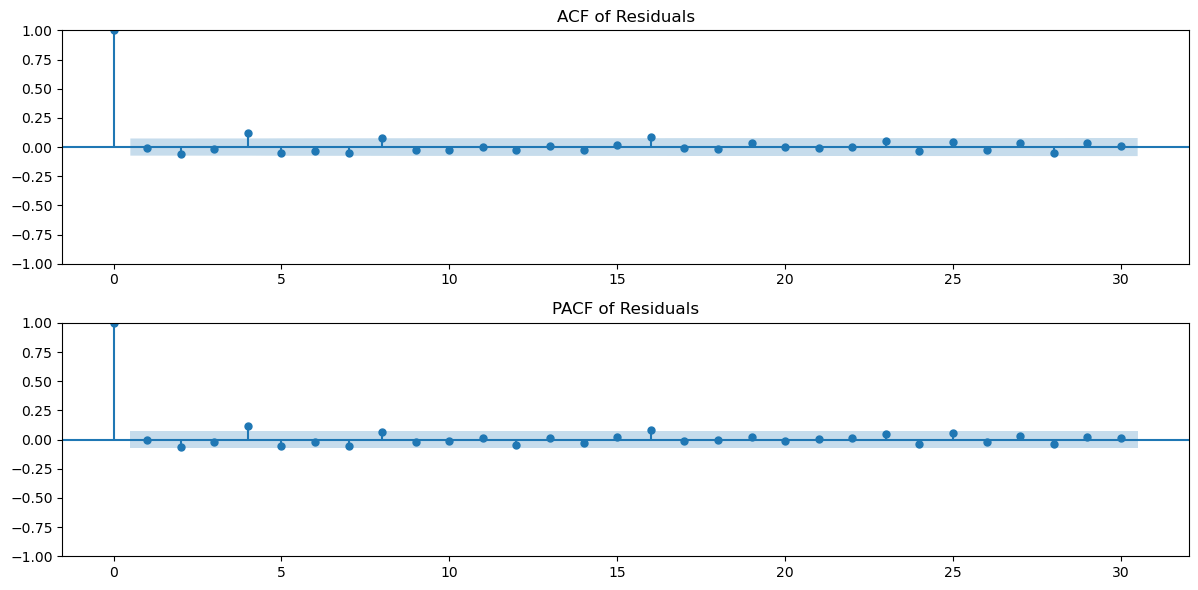

In [88]:
from statsmodels.tsa.arima.model import ARIMA

# Let's try an ARMA(p,q) or ARIMA(p,d,q). Since we found s1 is stationary via ADF, d=0 might suffice.
p, d, q = 1, 0, 1  # as an example guess
model = ARIMA(s1_series, order=(p, d, q))
results = model.fit()

print(results.summary())

# Residual diagnostics
resid = results.resid

# Plot the residuals ACF/PACF
fig, axes = plt.subplots(2,1,figsize=(12,6))
sm.graphics.tsa.plot_acf(resid, lags=30, ax=axes[0])
axes[0].set_title("ACF of Residuals")
sm.graphics.tsa.plot_pacf(resid, lags=30, ax=axes[1])
axes[1].set_title("PACF of Residuals")
plt.tight_layout()
plt.show()

# If the residuals are white noise, the ACF/PACF should show no significant spikes.


Iteration:      5,   Func. Count:     31,   Neg. LLF: 2299.4153866992747
Iteration:     10,   Func. Count:     58,   Neg. LLF: 2001.794160916745
Iteration:     15,   Func. Count:     82,   Neg. LLF: 2001.7814338405751
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2001.7814338405756
            Iterations: 15
            Function evaluations: 82
            Gradient evaluations: 15
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -2001.78
Distribution:      Standardized Student's t   AIC:                           4011.56
Method:                  Maximum Likelihood   BIC:                           4029.82
                                              No. Observations

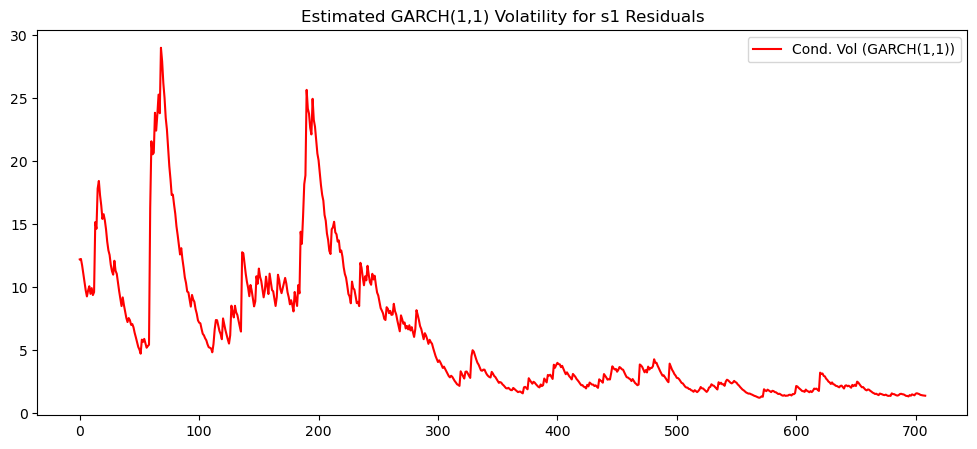

In [89]:
# pip install arch
from arch import arch_model

# We'll feed it the residuals from the ARIMA model to isolate volatility
# or directly on s1_series if we want a pure GARCH on s1 (assuming mean is near zero or constant).
resid_for_garch = results.resid if 'results' in locals() else s1_series

# Let's try a basic GARCH(1,1)
garch_model = arch_model(resid_for_garch, p=1, q=1, mean='Zero', vol='GARCH', dist='t')
garch_res = garch_model.fit(update_freq=5)
print(garch_res.summary())

# Retrieve conditional volatility estimates
cond_vol = garch_res.conditional_volatility

plt.figure(figsize=(12,5))
plt.plot(cond_vol, color='red', label='Cond. Vol (GARCH(1,1))')
plt.title("Estimated GARCH(1,1) Volatility for s1 Residuals")
plt.legend()
plt.show()


In [90]:
import numpy as np
import scipy.stats as st

# Fit normal:
mu_norm, sigma_norm = st.norm.fit(s1_series)
# Fit Student-t:
df_t, loc_t, scale_t = st.t.fit(s1_series)  # degrees of freedom, location, scale

print("Normal Fit:", mu_norm, sigma_norm)
print("Student-t Fit:", df_t, loc_t, scale_t)

# You can compare log-likelihood or AIC for each fit:
loglik_norm = np.sum(np.log(st.norm.pdf(s1_series, mu_norm, sigma_norm)))
loglik_t = np.sum(np.log(st.t.pdf(s1_series, df_t, loc_t, scale_t)))

n = len(s1_series)
AIC_norm = 2*2 - 2*loglik_norm       # 2 parameters => mean, std
AIC_t = 2*3 - 2*loglik_t            # 3 parameters => df, loc, scale

print("AIC Normal:", AIC_norm)
print("AIC t:", AIC_t)


Normal Fit: -19.609785737456114 35.75942896415078
Student-t Fit: 1.0419898279739277 -3.5194938273891045 9.68811520535327
AIC Normal: 7087.977066012592
AIC t: 6749.692255253885


### Pair 2: 7. CBT.TU versus CBT.US × 0.7894

In [49]:
# Y instrument: CBT.TU
df_Y = t_ivm[(t_ivm['exchange_code'] == 'CBT') & (t_ivm['futures_code'] == 'TU')]
df_Y_second = select_second_month(df_Y)
df_Y_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta1,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination
0,2021-12-03,CBT,TU,TU,1M,109.242188,0.016468,-0.004078,-0.004768,0.000669,...,-0.850216,50.903726,29386.933092,5.827710e+05,-4.109265e+08,-2.431571e+10,-0.012035,0.006634,31.0,31.0
1,2021-12-06,CBT,TU,TU,1M,109.150000,0.016263,-0.005552,-0.004772,0.000832,...,-1.154042,60.283215,39043.700180,7.891772e+05,-4.662192e+08,-2.611277e+10,-0.012525,0.006625,31.0,31.0
2,2021-12-07,CBT,TU,TU,1M,109.040625,0.016424,-0.004993,-0.003925,0.001013,...,-0.922880,78.118617,23977.412496,-7.921378e+04,-2.089281e+08,-7.607722e+09,-0.011808,0.007551,31.0,31.0
3,2021-12-08,CBT,TU,TU,1M,109.065625,0.015349,-0.003759,-0.003169,0.001162,...,-0.831807,126.436080,35311.877661,-1.394790e+06,-5.537103e+08,-2.056880e+10,-0.009903,0.006238,31.0,31.0
4,2021-12-09,CBT,TU,TU,1M,109.039062,0.015355,-0.003979,-0.001998,0.000823,...,-0.903386,88.575862,36291.880019,-7.480978e+05,-4.461545e+08,-1.056958e+10,-0.008687,0.006601,31.0,31.0


In [47]:
# Z instrument: CBT.US
df_Z = t_ivm[(t_ivm['exchange_code'] == 'CBT') & (t_ivm['futures_code'] == 'US')]
df_Z_second = select_second_month(df_Z)
df_Z_second = df_Z_second.copy()
df_Z_second['futures_adj'] = df_Z_second['futures'] * 0.7894
df_Z_second.head()

,date,exchange_code,futures_code,option_code,expiration,futures,atm,rr25,rr10,fly25,...,beta2,beta3,beta4,beta5,beta6,min_money,max_money,days_expiration,days_termination,futures_adj
0,2021-12-03,CBT,US,US,1M,162.709821,0.107847,0.007096,0.018796,0.003367,...,6.724124,13.286012,-281.719028,-2317.172013,25987.918900,-0.071269,0.098269,31.0,31.0,128.443133
1,2021-12-06,CBT,US,US,1M,161.140453,0.103458,0.001134,0.007704,0.002821,...,6.565345,48.714279,-480.779410,-6268.082671,64819.069390,-0.069529,0.085734,31.0,31.0,127.204274
2,2021-12-07,CBT,US,US,1M,160.203640,0.096955,0.000365,0.004507,0.002190,...,5.612642,39.577981,280.500722,-5139.060144,-19408.259457,-0.066813,0.083370,31.0,31.0,126.464754
3,2021-12-08,CBT,US,US,1M,159.132898,0.092402,-0.000578,0.002729,0.001940,...,5.469011,54.549282,434.971127,-8477.950753,-15427.808922,-0.065051,0.077948,31.0,31.0,125.619510
4,2021-12-09,CBT,US,US,1M,159.624657,0.093742,-0.002043,0.000406,0.002458,...,6.989844,64.648622,-334.945390,-8916.140117,69667.097312,-0.065556,0.081113,31.0,31.0,126.007704


In [51]:
df_pair2 = pd.merge(
    df_Y_second[['date', 'futures']],
    df_Z_second[['date', 'futures_adj']],
    on='date',
    how='inner'
)
df_pair2.rename(columns={'futures': 'Y', 'futures_adj': 'Z'}, inplace=True)
df_pair2.head()

,date,Y,Z
0,2021-12-03,109.242188,128.443133
1,2021-12-06,109.150000,127.204274
2,2021-12-07,109.040625,126.464754
3,2021-12-08,109.065625,125.619510
4,2021-12-09,109.039062,126.007704


In [54]:
df_pair2['s2'] = df_pair2['Z'] - df_pair2['Y']
df_pair2.head()

,date,Y,Z,s2
0,2021-12-03,109.242188,128.443133,19.200946
1,2021-12-06,109.150000,127.204274,18.054274
2,2021-12-07,109.040625,126.464754,17.424129
3,2021-12-08,109.065625,125.619510,16.553885
4,2021-12-09,109.039062,126.007704,16.968641


The IVS table gives is entore volatility surfaces

In [5]:
t_ivs = fetch_quandl_table('AR/IVS', avoid_download=False)
print(t_ivs.shape)
t_ivs.iloc[[0,1,2,-3,-2,-1],:8]

Data file /Users/anandtheerthanakhate/quandl_data_table_downloads/AR/IVS_20250110.zip size 776588872 exists already, no need to download
(5688897, 49)


,exchange_code,futures_code,option_code,expiration,date,dnsvol,p01dvol,p05dvol
0,NYX,EBM,EBM,K2020,2019-10-30,0.125231,0.166641,0.139948
1,NYX,EBM,EBM,K2020,2019-10-31,0.121587,0.163100,0.142994
2,NYX,EBM,EBM,K2020,2019-11-01,0.119784,0.162309,0.138984
5688894,NYX,EBM,EBM,K2020,2019-10-25,0.123797,0.164250,0.132582
5688895,NYX,EBM,EBM,K2020,2019-10-28,0.122919,0.165923,0.135023
5688896,NYX,EBM,EBM,K2020,2019-10-29,0.123054,0.166411,0.134985


In [6]:
t_ivs.columns

Index(['exchange_code', 'futures_code', 'option_code', 'expiration', 'date',
       'dnsvol', 'p01dvol', 'p05dvol', 'p10dvol', 'p15dvol', 'p20dvol',
       'p25dvol', 'p30dvol', 'p35dvol', 'p40dvol', 'p45dvol', 'p50dvol',
       'p55dvol', 'p60dvol', 'p65dvol', 'p70dvol', 'p75dvol', 'p80dvol',
       'p85dvol', 'p90dvol', 'p95dvol', 'p99dvol', 'c01dvol', 'c05dvol',
       'c10dvol', 'c15dvol', 'c20dvol', 'c25dvol', 'c30dvol', 'c35dvol',
       'c40dvol', 'c45dvol', 'c50dvol', 'c55dvol', 'c60dvol', 'c65dvol',
       'c70dvol', 'c75dvol', 'c80dvol', 'c85dvol', 'c90dvol', 'c95dvol',
       'c99dvol', 'days_expiration'],
      dtype='object')

Exchanges include CME, ICE and others

In [7]:
t_ivm.groupby('exchange_code')['futures_code'].count()

exchange_code
CBT     946146
CME    1292003
CMX     333447
ICE    1480778
NYM     846157
NYX     452273
Name: futures_code, dtype: int64

The time series of Dec 2024 E-Mini contract futures option skew model values

In [8]:
t_ivm.loc[(t_ivm.exchange_code=='CME') & (t_ivm.futures_code=='ES') & (t_ivm.option_code=='ES')& (t_ivm.expiration=='Z2024')].iloc[[0, 1,-1]].transpose()

,412,1815,5349812
exchange_code,CME,CME,CME
futures_code,ES,ES,ES
option_code,ES,ES,ES
expiration,Z2024,Z2024,Z2024
date,2024-12-16,2023-07-27,2024-12-13
futures,6080.5,4808.0,6055.5
atm,0.109168,0.160513,0.086164
rr25,-0.022198,-0.062816,-0.017122
rr10,-0.054357,-0.127251,-0.039291
fly25,0.004134,0.002873,0.002909


In [9]:
pd.to_datetime( t_ivm.date , format='%Y-%m-%d')

0         2024-12-16
1         2024-12-16
2         2024-12-16
3         2024-12-16
4         2024-12-16
             ...    
5350799   2024-12-16
5350800   2024-12-16
5350801   2024-12-16
5350802   2024-12-16
5350803   2024-12-16
Name: date, Length: 5350804, dtype: datetime64[ns]

The dates come as strings, here we convert them to more useful objects

In [10]:
fc_fix_date = t_ivm.copy()
fc_fix_date['Date'] = pd.to_datetime( fc_fix_date.date , format='%Y-%m-%d')

In [11]:
fut_curve_data = fc_fix_date.set_index(['exchange_code', 'futures_code','option_code','expiration', 'Date'])
fut_curve_data.sort_index(inplace=True)

In [12]:
es_fut_curve_data = fut_curve_data.loc[('CME','ES','ES')]
es_fut_curve_data.loc['Z2014'].iloc[[0, -1]].transpose()

Date,2013-12-23,2014-12-18
date,2013-12-23,2014-12-18
futures,1802.2,2065.0
atm,0.155901,0.162534
rr25,-0.055657,-0.001957
rr10,-0.108066,-0.0098
fly25,0.002523,0.006448
fly10,0.016919,0.028524
beta1,-0.282516,-0.138761
beta2,0.074599,255.483612
beta3,0.967884,-2246.910245


We can now plot daily futures prices, in this case for about a decade ago

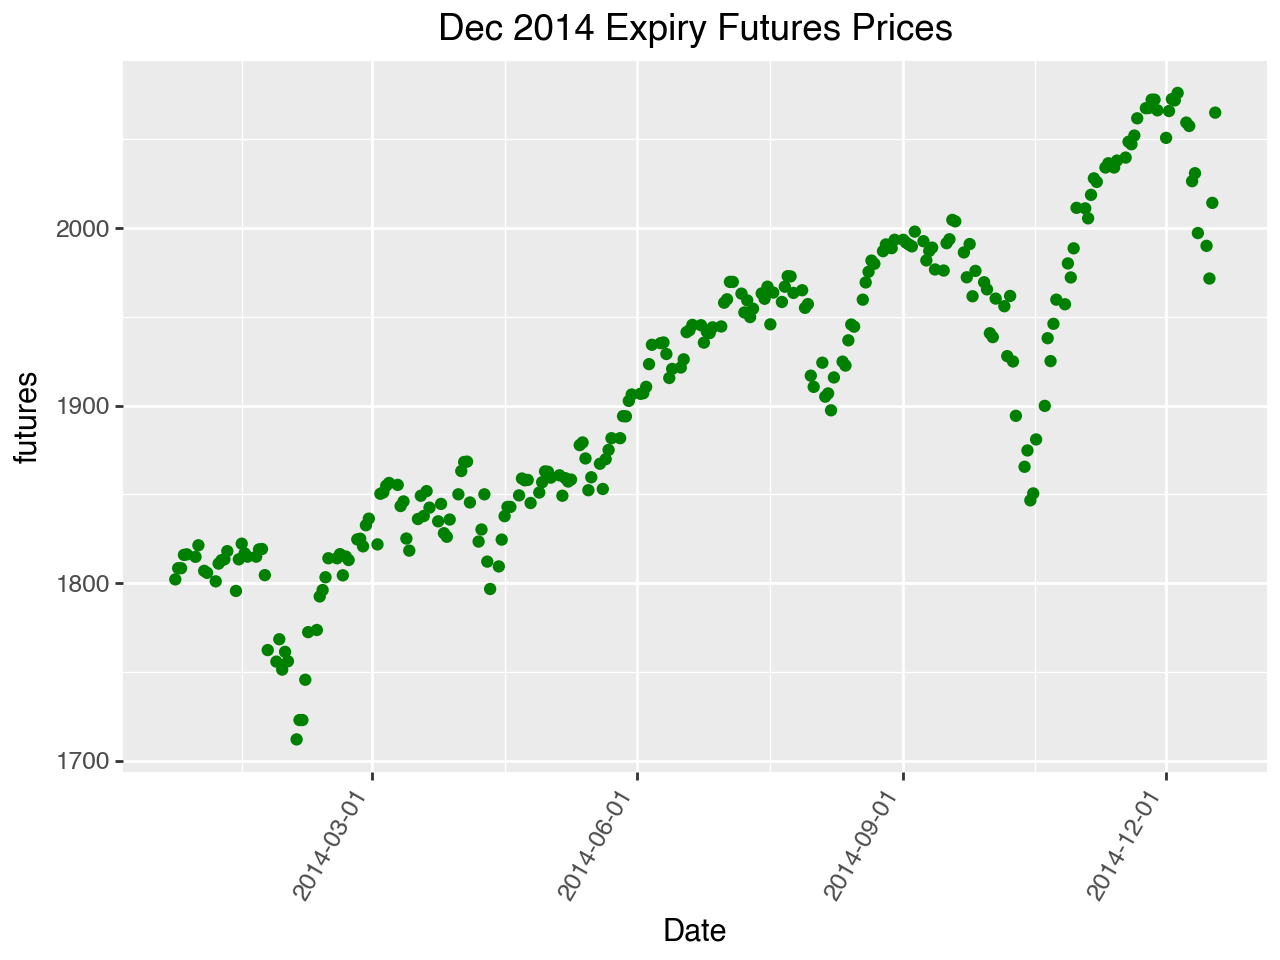

In [13]:
(
    p9.ggplot(
        es_fut_curve_data.loc['Z2014'].reset_index(),
        p9.aes(x='Date', y='futures')
    )
    + p9.geom_point(color='green')
    + p9.theme(axis_text_x=p9.element_text(rotation=60, hjust=1))
    + p9.ggtitle('Dec 2014 Expiry Futures Prices')
)

### The OptionWorks Volatility Parameterization

In [14]:
def vols(r):
    moneyness = pd.Series(np.linspace(start=r.min_money, stop=r.max_money, num=100))
    vola = r.atm + (r.beta1*moneyness + r.beta2*moneyness**2 + r.beta3*moneyness**3
                     + r.beta4*moneyness**4 + r.beta5*moneyness**5 + r.beta6*moneyness**6)
    vola.name="ImplVol"
    future = r.futures * np.exp(moneyness)
    return pd.DataFrame({"Dec 2014 Emini Future": future, "Moneyness": moneyness, "ImplVol": vola})


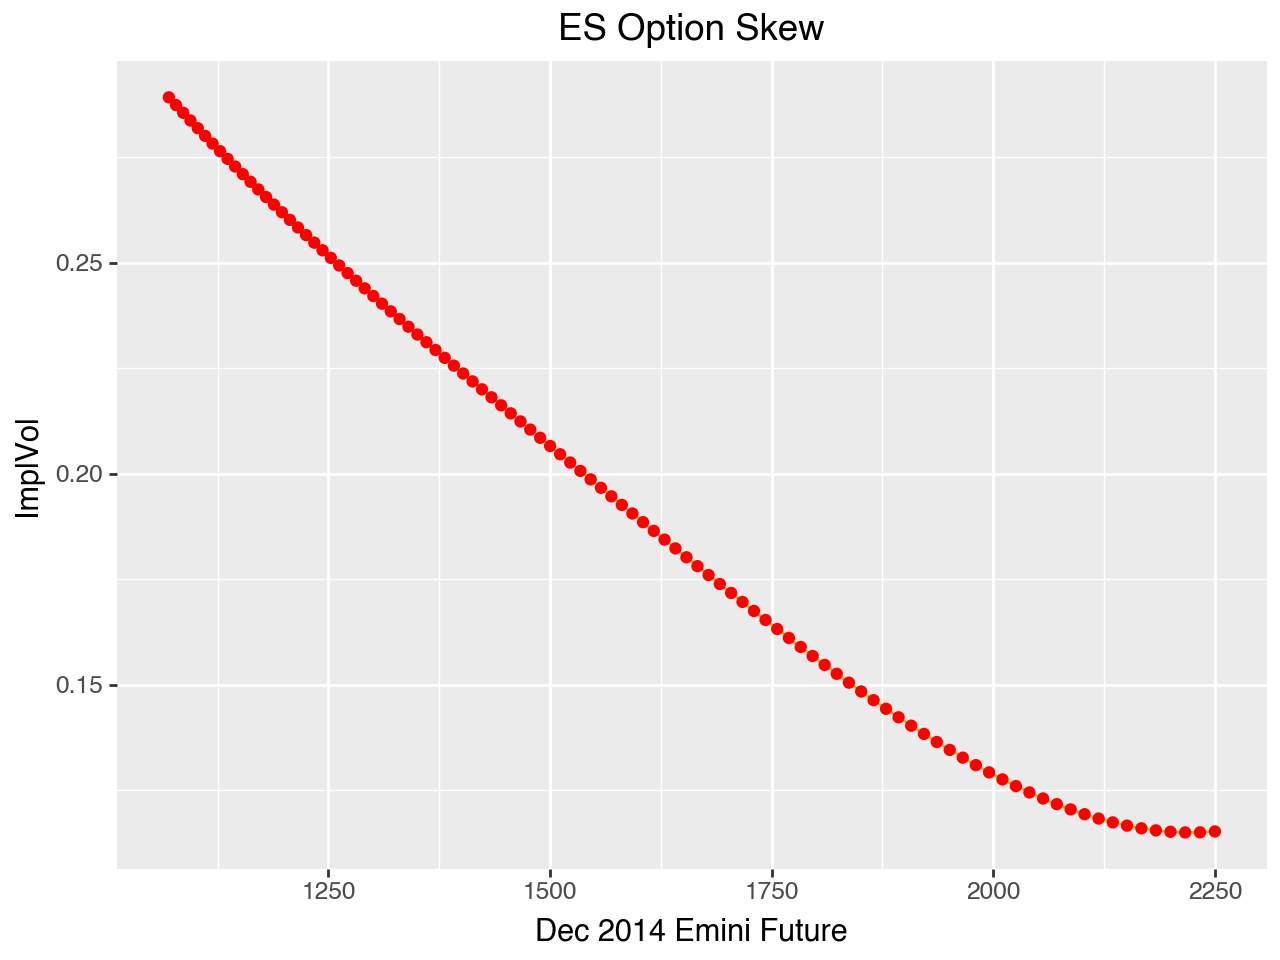

In [15]:
v = vols(es_fut_curve_data.loc['Z2014'].iloc[0])
(
    p9.ggplot(v, p9.aes(x='Dec 2014 Emini Future', y='ImplVol'))
    + p9.geom_line(color='orange')
    + p9.geom_point(color='red')
    + p9.ggtitle('ES Option Skew')
)